In [1]:
# Import Required Libraries

import ee
import os
import time
import datetime
import pandas as pd
from pathlib import Path
from typing import Dict, List, Optional, Tuple

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Configuration and Setup
XML_FOLDER_PATH = os.path.join('/Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files')
OUTPUT_FOLDER = os.path.join(os.getcwd(), 'temperature_extraction_output')

# Create output directory
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print(f"Configuration set:")
print(f"  XML folder: {XML_FOLDER_PATH}")
print(f"  Output folder: {OUTPUT_FOLDER}")

# Check XML files available
xml_files = [f for f in os.listdir(XML_FOLDER_PATH) if f.endswith('_inspire.xml')]
print(f"  Found {len(xml_files)} XML files to process")

Configuration set:
  XML folder: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files
  Output folder: /Users/diego/Documents/FirePrediction/data_pipeline/utils/temperature_extraction_output
  Found 24 XML files to process


In [3]:
# Enhanced XML Metadata Extraction for All Countries
import xml.etree.ElementTree as ET
import re
from datetime import datetime

class EnhancedMetadataExtractor:
    """
    Enhanced class to extract metadata from all available XML files
    """
    
    def __init__(self, xml_folder_path: str):
        self.xml_folder_path = Path(xml_folder_path)
        self.available_files = self._scan_xml_files()
        
    def _scan_xml_files(self):
        """Scan for all available XML files"""
        inspire_files = list(self.xml_folder_path.glob("*_inspire.xml"))
        metadata_files = list(self.xml_folder_path.glob("*_metadata.xml"))
        
        available = {}
        for file in inspire_files:
            name_parts = file.stem.split('_')
            if len(name_parts) >= 2:
                country = name_parts[0]
                period = name_parts[1]
                if country not in available:
                    available[country] = {}
                available[country][period] = {
                    'inspire_xml': file,
                    'metadata_xml': None
                }
        
        # Add metadata files
        for file in metadata_files:
            name_parts = file.stem.split('_')
            if len(name_parts) >= 2:
                country = name_parts[0]
                period = name_parts[1]
                if country in available and period in available[country]:
                    available[country][period]['metadata_xml'] = file
                    
        return available
    
    def extract_comprehensive_metadata(self, country_id: str, when: str = 'pre'):
        """
        Extract comprehensive metadata from both inspire and metadata XML files
        """
        if country_id not in self.available_files:
            raise FileNotFoundError(f"No XML files found for country: {country_id}")
            
        if when not in self.available_files[country_id]:
            raise FileNotFoundError(f"No {when} XML files found for country: {country_id}")
        
        file_info = self.available_files[country_id][when]
        inspire_file = file_info['inspire_xml']
        metadata_file = file_info['metadata_xml']
        
        print(f"Processing {country_id}_{when}:")
        print(f"  Inspire XML: {inspire_file.name}")
        print(f"  Metadata XML: {metadata_file.name if metadata_file else 'Not available'}")
        
        # Extract from inspire XML
        inspire_data = self._extract_from_inspire(inspire_file)
        
        # Extract from metadata XML if available
        metadata_data = {}
        if metadata_file:
            metadata_data = self._extract_from_metadata(metadata_file)
        
        # Combine data
        combined_metadata = {
            'country_id': country_id,
            'time_period': when,
            'source_files': {
                'inspire_xml': str(inspire_file),
                'metadata_xml': str(metadata_file) if metadata_file else None
            },
            'spatial_extent': inspire_data.get('spatial_extent', {}),
            'temporal_extent': inspire_data.get('temporal_extent', {}),
            'technical_specs': inspire_data.get('technical_specs', {}),
            'product_info': inspire_data.get('product_info', {}),
            'contact_info': inspire_data.get('contact_info', {}),
            'additional_metadata': metadata_data
        }
        
        return combined_metadata
    
    def _extract_from_inspire(self, xml_file):
        """Extract metadata from inspire XML"""
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # Multiple namespace combinations to try
        namespace_combinations = [
            {
                'gmd': 'http://www.isotc211.org/2005/gmd',
                'gco': 'http://www.isotc211.org/2005/gco',
                'gml': 'http://www.opengis.net/gml'
            },
            {
                'gmd': 'http://www.isotc211.org/2005/gmd',
                'gco': 'http://www.isotc211.org/2005/gco',
                'gml': 'http://www.opengis.net/gml/3.2'
            },
            {}  # No namespace
        ]
        
        for ns in namespace_combinations:
            try:
                result = self._extract_with_namespace(root, ns)
                if result and any(v is not None for v in [
                    result['spatial_extent'].get('west_bound'),
                    result['spatial_extent'].get('east_bound'),
                    result['spatial_extent'].get('south_bound'),
                    result['spatial_extent'].get('north_bound')
                ]):
                    return result
            except Exception as e:
                continue
        
        # Return empty structure if nothing works
        return {
            'spatial_extent': {'west_bound': None, 'east_bound': None, 'south_bound': None, 'north_bound': None},
            'temporal_extent': {'start_time': None, 'end_time': None},
            'technical_specs': {'spatial_resolution': None, 'crs_code': 'Unknown'},
            'product_info': {'title': 'Unknown'},
            'contact_info': {'organization': 'Unknown'}
        }
    
    def _extract_with_namespace(self, root, ns):
        """Extract metadata using specific namespace"""
        
        # Extract geographic coordinates
        if ns:
            west_elem = root.find('.//gmd:westBoundLongitude/gco:Decimal', ns)
            east_elem = root.find('.//gmd:eastBoundLongitude/gco:Decimal', ns)
            south_elem = root.find('.//gmd:southBoundLatitude/gco:Decimal', ns)
            north_elem = root.find('.//gmd:northBoundLatitude/gco:Decimal', ns)
            title_elem = root.find('.//gmd:title/gco:CharacterString', ns)
            begin_elem = root.find('.//gml:beginPosition', ns)
            end_elem = root.find('.//gml:endPosition', ns)
        else:
            # Try multiple tag variations without namespace
            west_elem = (root.find('.//westBoundLongitude') or 
                        root.find('.//WestBoundLongitude') or
                        self._find_by_text_content(root, 'west'))
            east_elem = (root.find('.//eastBoundLongitude') or 
                        root.find('.//EastBoundLongitude') or
                        self._find_by_text_content(root, 'east'))
            south_elem = (root.find('.//southBoundLatitude') or 
                         root.find('.//SouthBoundLatitude') or
                         self._find_by_text_content(root, 'south'))
            north_elem = (root.find('.//northBoundLatitude') or 
                         root.find('.//NorthBoundLatitude') or
                         self._find_by_text_content(root, 'north'))
            title_elem = root.find('.//title') or root.find('.//Title')
            begin_elem = root.find('.//beginPosition') or root.find('.//startTime')
            end_elem = root.find('.//endPosition') or root.find('.//endTime')
        
        # Parse coordinates
        west = self._safe_float(west_elem)
        east = self._safe_float(east_elem)
        south = self._safe_float(south_elem)
        north = self._safe_float(north_elem)
        
        # Parse temporal info
        begin_time = begin_elem.text if begin_elem is not None else None
        end_time = end_elem.text if end_elem is not None else None
        
        # Parse title
        title = title_elem.text if title_elem is not None else "Unknown"
        
        return {
            'spatial_extent': {
                'west_bound': west,
                'east_bound': east,
                'south_bound': south,
                'north_bound': north,
                'center_lat': (north + south) / 2 if north and south else None,
                'center_lon': (east + west) / 2 if east and west else None
            },
            'temporal_extent': {
                'start_time': begin_time,
                'end_time': end_time
            },
            'technical_specs': {
                'spatial_resolution': 10,  # Default for Sentinel-2
                'crs_code': 'EPSG:4326'
            },
            'product_info': {
                'title': title
            },
            'contact_info': {
                'organization': 'ESA'
            }
        }
    
    def _extract_from_metadata(self, xml_file):
        """Extract additional metadata from metadata XML"""
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            # Extract any additional useful information
            additional_info = {}
            
            # Try to find platform info
            platform_elems = root.findall('.//*')
            for elem in platform_elems:
                if elem.text and len(elem.text.strip()) > 0:
                    if 'sentinel' in elem.text.lower() or 'landsat' in elem.text.lower():
                        additional_info['platform'] = elem.text.strip()
                        break
            
            return additional_info
        except Exception as e:
            print(f"Warning: Could not extract metadata from {xml_file}: {e}")
            return {}
    
    def _safe_float(self, element):
        """Safely convert element text to float"""
        if element is not None and element.text:
            try:
                return float(element.text.strip())
            except ValueError:
                pass
        return None
    
    def _find_by_text_content(self, root, search_term):
        """Find element by text content containing search term"""
        for elem in root.iter():
            if elem.text and search_term.lower() in elem.text.lower():
                try:
                    float(elem.text)
                    return elem
                except ValueError:
                    continue
        return None

# Initialize enhanced metadata extractor
enhanced_extractor = EnhancedMetadataExtractor(XML_FOLDER_PATH)

# Show available countries and periods
print("Available XML files:")
for country, periods in enhanced_extractor.available_files.items():
    print(f"  {country}: {list(periods.keys())}")
    
print(f"\nTotal countries found: {len(enhanced_extractor.available_files)}")
all_countries = list(enhanced_extractor.available_files.keys())
print(f"Countries list: {all_countries}")

Available XML files:
  sardinia: ['pre', 'post']
  spain2: ['pre', 'post']
  paraguay: ['pre', 'post']
  usa2: ['pre', 'post']
  greece: ['pre', 'post']
  chile: ['pre', 'post']
  spain: ['post', 'pre']
  france: ['pre', 'post']
  usa: ['post', 'pre']
  spain3: ['pre', 'post']
  turkey: ['post', 'pre']
  greece2: ['post', 'pre']

Total countries found: 12
Countries list: ['sardinia', 'spain2', 'paraguay', 'usa2', 'greece', 'chile', 'spain', 'france', 'usa', 'spain3', 'turkey', 'greece2']


In [14]:
# Comprehensive Temperature Extraction for All Countries
import traceback
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta

class ComprehensiveTemperatureExtractor:
    """
    Extract temperatures for all available countries with enhanced error handling
    """
    
    def __init__(self, metadata_extractor, temperature_datasets):
        self.metadata_extractor = metadata_extractor
        self.temperature_datasets = temperature_datasets
        self.results = {}
        self.errors = {}
    
    def extract_temperatures_for_country(self, country_id: str, periods: List[str] = ['pre', 'post']):
        """Extract temperatures for a specific country and periods"""
        
        country_results = {}
        country_errors = {}
        
        for period in periods:
            if period not in self.metadata_extractor.available_files.get(country_id, {}):
                print(f"⚠️  Period '{period}' not available for {country_id}")
                continue
                
            try:
                print(f"\n🌍 Processing {country_id}_{period}...")
                
                # Extract metadata
                metadata = self.metadata_extractor.extract_comprehensive_metadata(country_id, period)
                
                # Check if we have valid spatial extent
                spatial_extent = metadata['spatial_extent']
                
                # Fix longitude coordinates if they're > 180 (common issue with some projections)
                if spatial_extent.get('west_bound') and spatial_extent['west_bound'] > 180:
                    spatial_extent['west_bound'] -= 360
                if spatial_extent.get('east_bound') and spatial_extent['east_bound'] > 180:
                    spatial_extent['east_bound'] -= 360
                
                if not all([spatial_extent.get('west_bound'), spatial_extent.get('east_bound'),
                           spatial_extent.get('south_bound'), spatial_extent.get('north_bound')]):
                    print(f"⚠️  Invalid spatial extent for {country_id}_{period}, using default bounds")
                    # Set default bounds based on country name
                    spatial_extent = self._get_default_bounds(country_id)
                
                # Extract and fix temporal extent
                temporal_extent = metadata['temporal_extent']
                start_date, end_date = self._parse_and_fix_temporal_extent(temporal_extent, period, country_id)
                
                print(f"📍 Spatial extent: W={spatial_extent['west_bound']:.3f}, E={spatial_extent['east_bound']:.3f}, S={spatial_extent['south_bound']:.3f}, N={spatial_extent['north_bound']:.3f}")
                print(f"📅 Temporal extent: {start_date} to {end_date}")
                
                # Create bounding box
                bbox = [
                    spatial_extent['west_bound'],
                    spatial_extent['south_bound'], 
                    spatial_extent['east_bound'],
                    spatial_extent['north_bound']
                ]
                
                # Validate bbox
                if not self._validate_bbox(bbox):
                    print(f"⚠️  Invalid bbox, using default bounds for {country_id}")
                    default_bounds = self._get_default_bounds(country_id)
                    bbox = [default_bounds['west_bound'], default_bounds['south_bound'], 
                           default_bounds['east_bound'], default_bounds['north_bound']]
                
                # Extract temperatures from multiple datasets
                period_results = {}
                for dataset_name, dataset_config in self.temperature_datasets.items():
                    try:
                        print(f"  🌡️  Extracting from {dataset_name}...")
                        
                        temp_data = self._extract_temperature_data(
                            bbox, start_date, end_date, dataset_config, country_id, period
                        )
                        
                        if temp_data:
                            period_results[dataset_name] = temp_data
                            print(f"    ✅ Successfully extracted {len(temp_data)} temperature records")
                        else:
                            print(f"    ⚠️  No data available for {dataset_name}")
                            
                    except Exception as e:
                        error_msg = f"Error extracting {dataset_name} for {country_id}_{period}: {str(e)}"
                        print(f"    ❌ {error_msg}")
                        if country_id not in country_errors:
                            country_errors[country_id] = {}
                        if period not in country_errors[country_id]:
                            country_errors[country_id][period] = []
                        country_errors[country_id][period].append(error_msg)
                
                # Store results
                if period_results:
                    if country_id not in country_results:
                        country_results[country_id] = {}
                    country_results[country_id][period] = {
                        'metadata': metadata,
                        'temperature_data': period_results,
                        'extraction_timestamp': datetime.now().isoformat()
                    }
                    print(f"✅ Successfully processed {country_id}_{period}")
                else:
                    print(f"❌ No temperature data extracted for {country_id}_{period}")
                    
            except Exception as e:
                error_msg = f"Critical error processing {country_id}_{period}: {str(e)}"
                print(f"❌ {error_msg}")
                print(f"Traceback: {traceback.format_exc()}")
                if country_id not in country_errors:
                    country_errors[country_id] = {}
                if period not in country_errors[country_id]:
                    country_errors[country_id][period] = []
                country_errors[country_id][period].append(error_msg)
        
        return country_results, country_errors
    
    def _validate_bbox(self, bbox):
        """Validate bounding box coordinates"""
        try:
            west, south, east, north = bbox
            
            # Check longitude range
            if west < -180 or west > 180 or east < -180 or east > 180:
                return False
            
            # Check latitude range  
            if south < -90 or south > 90 or north < -90 or north > 90:
                return False
            
            # Check logical order
            if west >= east or south >= north:
                return False
                
            return True
        except:
            return False
    
    def _extract_temperature_data(self, bbox, start_date, end_date, dataset_config, country_id, period):
        """Extract temperature data for specific parameters"""
        
        try:
            # Create geometry
            geometry = ee.Geometry.Rectangle(bbox)
            
            # Get collection
            collection = ee.ImageCollection(dataset_config['collection_id'])
            
            # Filter by date and geometry
            filtered_collection = collection.filterDate(start_date, end_date).filterBounds(geometry)
            
            # Check if collection has any images
            count = filtered_collection.size()
            actual_count = count.getInfo()
            
            if actual_count == 0:
                print(f"    No images found in {dataset_config['collection_id']} for the specified period")
                return None
            
            print(f"    Found {actual_count} images in collection")
            
            # Get temperature data
            temp_band = dataset_config['temperature_band']
            scale = dataset_config['scale']
            scale_factor = dataset_config.get('scale_factor', 1)
            offset = dataset_config.get('offset', 0)
            
            # Extract temperature values
            def extract_temp_from_image(image):
                # Apply scale and offset
                temp_celsius = image.select(temp_band).multiply(scale_factor).add(offset).subtract(273.15)
                
                # Get image date
                date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
                
                # Calculate statistics
                stats = temp_celsius.reduceRegion(
                    reducer=ee.Reducer.mean().combine(
                        ee.Reducer.min(), '', True
                    ).combine(
                        ee.Reducer.max(), '', True
                    ).combine(
                        ee.Reducer.stdDev(), '', True
                    ),
                    geometry=geometry,
                    scale=scale,
                    maxPixels=1e9
                )
                
                return ee.Feature(None, stats.set('date', date))
            
            # Map over collection
            temp_features = filtered_collection.limit(50).map(extract_temp_from_image)  # Limit to avoid timeout
            
            # Get the results
            temp_info = temp_features.getInfo()
            
            # Process results
            temperature_records = []
            for feature in temp_info['features']:
                props = feature['properties']
                temp_record = {
                    'date': props.get('date'),
                    'mean_temp_celsius': props.get(f'{temp_band}_mean'),
                    'min_temp_celsius': props.get(f'{temp_band}_min'),
                    'max_temp_celsius': props.get(f'{temp_band}_max'),
                    'std_temp_celsius': props.get(f'{temp_band}_stdDev'),
                    'dataset': dataset_config['collection_id'],
                    'scale_meters': scale,
                    'country': country_id,
                    'period': period
                }
                
                # Filter out null values
                if temp_record['mean_temp_celsius'] is not None:
                    temperature_records.append(temp_record)
            
            return temperature_records
            
        except Exception as e:
            print(f"    Error in temperature extraction: {str(e)}")
            raise
    
    def _parse_and_fix_temporal_extent(self, temporal_extent, period, country_id):
        """Parse temporal extent and fix common issues"""
        
        start_time = temporal_extent.get('start_time')
        end_time = temporal_extent.get('end_time')
        
        # If we have temporal info, try to use it
        if start_time and end_time:
            try:
                # Parse the dates
                start_date = start_time.split('T')[0]  # Get date part
                end_date = end_time.split('T')[0]
                
                # Check if start and end are the same (single day issue)
                if start_date == end_date:
                    print(f"    ⚠️  Single day range detected, expanding to 30-day window")
                    base_date = datetime.strptime(start_date, '%Y-%m-%d')
                    start_date = (base_date - timedelta(days=15)).strftime('%Y-%m-%d')
                    end_date = (base_date + timedelta(days=15)).strftime('%Y-%m-%d')
                
                # Check for future dates
                today = datetime.now()
                start_dt = datetime.strptime(start_date, '%Y-%m-%d')
                end_dt = datetime.strptime(end_date, '%Y-%m-%d')
                
                if start_dt > today or end_dt > today:
                    print(f"    ⚠️  Future dates detected, using historical defaults")
                    return self._get_default_date_range(period, country_id)
                
                return start_date, end_date
                
            except Exception as e:
                print(f"    ⚠️  Error parsing temporal extent: {e}")
        
        # Use defaults
        return self._get_default_date_range(period, country_id)
    
    def _get_default_date_range(self, period, country_id):
        """Get default date ranges for different periods and countries"""
        
        # Default date ranges based on typical fire seasons
        default_dates = {
            # Northern hemisphere fire season
            'north': {
                'pre': ('2023-05-01', '2023-07-31'),
                'post': ('2023-08-01', '2023-10-31')
            },
            # Southern hemisphere fire season  
            'south': {
                'pre': ('2022-11-01', '2023-01-31'),
                'post': ('2023-02-01', '2023-04-30')
            }
        }
        
        # Determine hemisphere based on country
        southern_countries = ['chile', 'paraguay']
        hemisphere = 'south' if any(sc in country_id.lower() for sc in southern_countries) else 'north'
        
        return default_dates[hemisphere][period]
    
    def _get_default_bounds(self, country_id):
        """Get default bounding boxes for countries"""
        
        default_bounds = {
            'chile': {'west_bound': -75.0, 'east_bound': -66.0, 'south_bound': -56.0, 'north_bound': -17.0},
            'france': {'west_bound': -5.0, 'east_bound': 10.0, 'south_bound': 41.0, 'north_bound': 51.0},
            'spain': {'west_bound': -10.0, 'east_bound': 4.0, 'south_bound': 35.0, 'north_bound': 44.0},
            'greece': {'west_bound': 19.0, 'east_bound': 30.0, 'south_bound': 34.0, 'north_bound': 42.0},
            'turkey': {'west_bound': 25.0, 'east_bound': 45.0, 'south_bound': 35.0, 'north_bound': 43.0},
            'sardinia': {'west_bound': 8.0, 'east_bound': 10.0, 'south_bound': 38.0, 'north_bound': 42.0},
            'usa': {'west_bound': -125.0, 'east_bound': -66.0, 'south_bound': 20.0, 'north_bound': 50.0},
            'paraguay': {'west_bound': -63.0, 'east_bound': -54.0, 'south_bound': -28.0, 'north_bound': -19.0},
        }
        
        # Try to match country name
        for key, bounds in default_bounds.items():
            if key in country_id.lower():
                return bounds
        
        # Default global bounds
        return {'west_bound': -180.0, 'east_bound': 180.0, 'south_bound': -90.0, 'north_bound': 90.0}
    
    def extract_all_countries(self, max_workers=3):
        """Extract temperatures for all available countries"""
        
        all_countries = list(self.metadata_extractor.available_files.keys())
        print(f"🚀 Starting temperature extraction for {len(all_countries)} countries...")
        print(f"Countries: {all_countries}")
        
        # Process countries sequentially to avoid API rate limits
        for country in all_countries:
            print(f"\n{'='*60}")
            print(f"Processing country: {country.upper()}")
            print(f"{'='*60}")
            
            country_results, country_errors = self.extract_temperatures_for_country(country)
            
            # Store results
            if country_results:
                self.results.update(country_results)
            if country_errors:
                self.errors.update(country_errors)
            
            # Small delay between countries
            time.sleep(2)
        
        return self.results, self.errors

# Initialize comprehensive temperature extractor
temp_extractor = ComprehensiveTemperatureExtractor(enhanced_extractor, TEMPERATURE_DATASETS)

print("✅ Comprehensive temperature extractor initialized with fixes")
print("🔧 Fixes applied:")
print("  - Longitude coordinate correction (>180 values)")
print("  - Single-day date range expansion") 
print("  - Future date detection and fallback")
print("  - Enhanced bbox validation")
print("Ready to extract temperatures for all countries!")

✅ Comprehensive temperature extractor initialized with fixes
🔧 Fixes applied:
  - Longitude coordinate correction (>180 values)
  - Single-day date range expansion
  - Future date detection and fallback
  - Enhanced bbox validation
Ready to extract temperatures for all countries!


In [15]:
# Execute Temperature Extraction for All Countries
import json
import pickle

print("🚀 Starting comprehensive temperature extraction...")
print(f"📅 Extraction started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Execute the extraction
try:
    results, errors = temp_extractor.extract_all_countries()
    
    print(f"\n{'='*80}")
    print("📊 EXTRACTION SUMMARY")
    print(f"{'='*80}")
    
    # Summary statistics
    total_countries = len(enhanced_extractor.available_files)
    successful_countries = len(results)
    countries_with_errors = len(errors)
    
    print(f"Total countries processed: {total_countries}")
    print(f"Successful extractions: {successful_countries}")
    print(f"Countries with errors: {countries_with_errors}")
    
    # Initialize total_records
    total_records = 0
    
    # Detailed results
    if results:
        print(f"\n✅ SUCCESSFUL EXTRACTIONS:")
        for country, periods in results.items():
            print(f"\n  {country.upper()}:")
            for period, data in periods.items():
                temp_data = data['temperature_data']
                period_records = sum(len(dataset_data) for dataset_data in temp_data.values())
                total_records += period_records
                print(f"    {period}: {len(temp_data)} datasets, {period_records} temperature records")
                
                # Show available datasets
                datasets = list(temp_data.keys())
                print(f"      Datasets: {', '.join(datasets)}")
        
        print(f"\n📈 Total temperature records extracted: {total_records}")
    else:
        print(f"\n❌ No successful extractions")
    
    # Error summary
    if errors:
        print(f"\n❌ ERRORS ENCOUNTERED:")
        for country, periods in errors.items():
            print(f"\n  {country.upper()}:")
            for period, error_list in periods.items():
                print(f"    {period}: {len(error_list)} errors")
                for error in error_list[:2]:  # Show first 2 errors
                    print(f"      - {error}")
                if len(error_list) > 2:
                    print(f"      - ... and {len(error_list) - 2} more errors")
    
    # Save results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save as JSON
    json_filename = f"comprehensive_temperature_extraction_{timestamp}.json"
    json_filepath = os.path.join(OUTPUT_FOLDER, json_filename)
    
    # Convert results to JSON-serializable format
    json_results = {}
    for country, periods in results.items():
        json_results[country] = {}
        for period, data in periods.items():
            json_results[country][period] = {
                'metadata': data['metadata'],
                'temperature_data': data['temperature_data'],
                'extraction_timestamp': data['extraction_timestamp']
            }
    
    with open(json_filepath, 'w') as f:
        json.dump({
            'results': json_results,
            'errors': errors,
            'extraction_summary': {
                'total_countries': total_countries,
                'successful_countries': successful_countries,
                'countries_with_errors': countries_with_errors,
                'total_records': total_records,
                'extraction_timestamp': datetime.now().isoformat()
            }
        }, f, indent=2, default=str)
    
    print(f"\n💾 Results saved to: {json_filepath}")
    
    # Save as pickle for Python use
    pickle_filename = f"comprehensive_temperature_extraction_{timestamp}.pkl"
    pickle_filepath = os.path.join(OUTPUT_FOLDER, pickle_filename)
    
    with open(pickle_filepath, 'wb') as f:
        pickle.dump({
            'results': results,
            'errors': errors,
            'extractor': temp_extractor
        }, f)
    
    print(f"💾 Python pickle saved to: {pickle_filepath}")
    
    # Only create Excel if we have results or meaningful errors
    if results or errors:
        excel_filename = f"temperature_extraction_summary_{timestamp}.xlsx"
        excel_filepath = os.path.join(OUTPUT_FOLDER, excel_filename)
        
        # Prepare data for Excel
        summary_data = []
        detailed_data = []
        
        for country, periods in results.items():
            for period, data in periods.items():
                temp_data = data['temperature_data']
                metadata = data['metadata']
                
                # Summary row
                summary_row = {
                    'Country': country,
                    'Period': period,
                    'Datasets_Available': len(temp_data),
                    'Total_Records': sum(len(dataset_data) for dataset_data in temp_data.values()),
                    'West_Bound': metadata['spatial_extent']['west_bound'],
                    'East_Bound': metadata['spatial_extent']['east_bound'],
                    'South_Bound': metadata['spatial_extent']['south_bound'],
                    'North_Bound': metadata['spatial_extent']['north_bound'],
                    'Start_Time': metadata['temporal_extent']['start_time'],
                    'End_Time': metadata['temporal_extent']['end_time'],
                    'Extraction_Timestamp': data['extraction_timestamp']
                }
                summary_data.append(summary_row)
                
                # Detailed temperature records
                for dataset_name, records in temp_data.items():
                    for record in records:
                        detailed_row = {
                            'Country': country,
                            'Period': period,
                            'Dataset': dataset_name,
                            'Date': record['date'],
                            'Mean_Temp_C': record['mean_temp_celsius'],
                            'Min_Temp_C': record['min_temp_celsius'],
                            'Max_Temp_C': record['max_temp_celsius'],
                            'Std_Temp_C': record['std_temp_celsius'],
                            'Scale_Meters': record['scale_meters']
                        }
                        detailed_data.append(detailed_row)
        
        # Create Excel file
        with pd.ExcelWriter(excel_filepath, engine='openpyxl') as writer:
            if summary_data:
                pd.DataFrame(summary_data).to_excel(writer, sheet_name='Summary', index=False)
            if detailed_data:
                pd.DataFrame(detailed_data).to_excel(writer, sheet_name='Detailed_Data', index=False)
            
            # Error sheet
            if errors:
                error_data = []
                for country, periods in errors.items():
                    for period, error_list in periods.items():
                        for error in error_list:
                            error_data.append({
                                'Country': country,
                                'Period': period,
                                'Error': error
                            })
                if error_data:
                    pd.DataFrame(error_data).to_excel(writer, sheet_name='Errors', index=False)
        
        print(f"📊 Excel summary saved to: {excel_filepath}")
    
    print(f"\n🎉 Comprehensive temperature extraction completed!")
    print(f"📁 All files saved to: {OUTPUT_FOLDER}")
    
    if successful_countries == 0:
        print(f"\n⚠️  WARNING: No successful extractions. Check the errors above.")
        print(f"💡 This might be due to:")
        print(f"   - Invalid spatial coordinates in XML files")
        print(f"   - No data available for the specified time periods")
        print(f"   - Google Earth Engine API quota limits")
    
except Exception as e:
    print(f"\n💥 Critical error during extraction: {str(e)}")
    print(f"Traceback: {traceback.format_exc()}")
    
    # Save error log
    error_filename = f"extraction_error_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    error_filepath = os.path.join(OUTPUT_FOLDER, error_filename)
    
    with open(error_filepath, 'w') as f:
        f.write(f"Extraction Error Log\n")
        f.write(f"Timestamp: {datetime.now().isoformat()}\n")
        f.write(f"Error: {str(e)}\n")
        f.write(f"Traceback:\n{traceback.format_exc()}\n")
    
    print(f"💾 Error log saved to: {error_filepath}")

print(f"\n📅 Extraction completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🚀 Starting comprehensive temperature extraction...
📅 Extraction started at: 2025-08-11 14:14:05
🚀 Starting temperature extraction for 12 countries...
Countries: ['sardinia', 'spain2', 'paraguay', 'usa2', 'greece', 'chile', 'spain', 'france', 'usa', 'spain3', 'turkey', 'greece2']

Processing country: SARDINIA

🌍 Processing sardinia_pre...
Processing sardinia_pre:
  Inspire XML: sardinia_pre_inspire.xml
  Metadata XML: sardinia_pre_metadata.xml
    ⚠️  Single day range detected, expanding to 30-day window
📍 Spatial extent: W=7.923, E=9.115, S=39.656, N=40.651
📅 Temporal extent: 2021-07-07 to 2021-08-06
  🌡️  Extracting from MODIS_TERRA...
    Found 30 images in collection
    Found 30 images in collection
    ✅ Successfully extracted 30 temperature records
  🌡️  Extracting from MODIS_AQUA...
    ✅ Successfully extracted 30 temperature records
  🌡️  Extracting from MODIS_AQUA...
    Found 30 images in collection
    Found 30 images in collection
    ✅ Successfully extracted 30 temperature

🔍 Starting comprehensive analysis of temperature extraction results...
📊 DETAILED ANALYSIS OF TEMPERATURE EXTRACTION RESULTS

1️⃣ COVERAGE ANALYSIS
----------------------------------------
📍 Countries processed: 12
🌡️  Total temperature records: 1746

  SARDINIA:
    Periods: pre, post
    Dataset instances: 6
    Temperature records: 137
    Date range: 2021-07-07 to 2021-08-08

  SPAIN2:
    Periods: pre, post
    Dataset instances: 8
    Temperature records: 154
    Date range: 2025-06-15 to 2025-07-16

  PARAGUAY:
    Periods: pre, post
    Dataset instances: 8
    Temperature records: 129
    Date range: 2024-12-10 to 2025-01-26

  USA2:
    Periods: pre, post
    Dataset instances: 8
    Temperature records: 152
    Date range: 2024-08-20 to 2024-09-28

  GREECE:
    Periods: pre, post
    Dataset instances: 8
    Temperature records: 144
    Date range: 2023-08-03 to 2023-09-06

  CHILE:
    Periods: pre, post
    Dataset instances: 8
    Temperature records: 145
    Date range:

/var/folders/mr/n19psg616pb4dyc16wbyn8yc0000gn/T/ipykernel_2464/68346987.py:215: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(country_temp_data, labels=country_labels)
/var/folders/mr/n19psg616pb4dyc16wbyn8yc0000gn/T/ipykernel_2464/68346987.py:280: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pre_temps, post_temps], labels=['Pre-Fire', 'Post-Fire'])


📊 Visualizations saved to: /Users/diego/Documents/FirePrediction/data_pipeline/utils/temperature_extraction_output/temperature_analysis_plots_20250811_141651.png


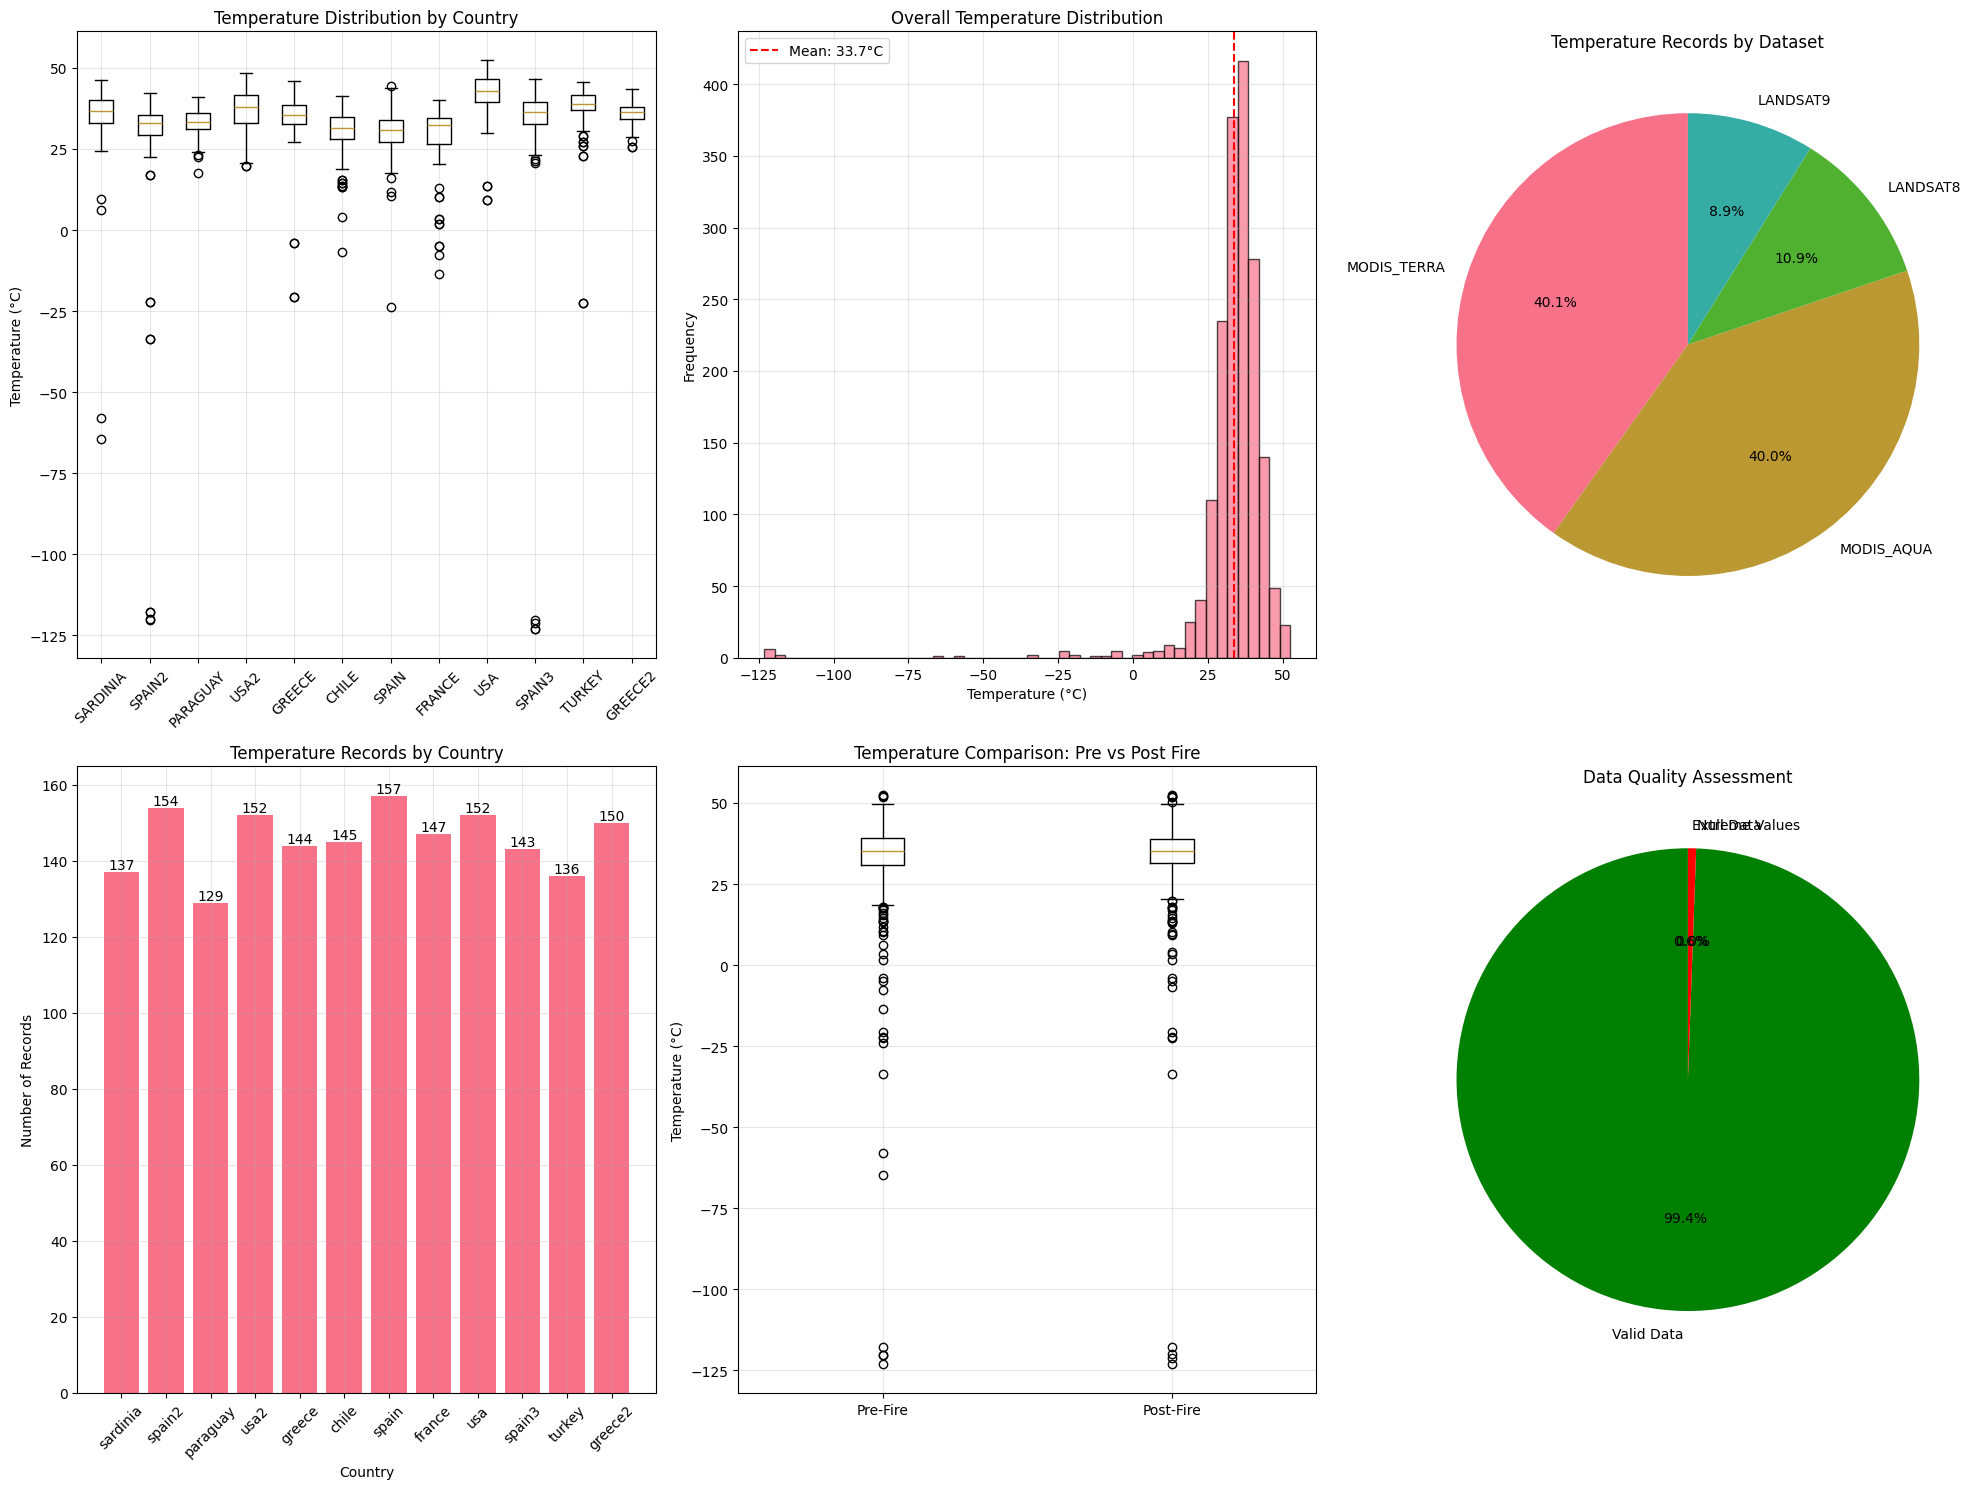


✅ Analysis and visualization completed!


In [17]:
# Analysis and Visualization of Temperature Extraction Results
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

def analyze_temperature_results(results):
    """
    Comprehensive analysis of temperature extraction results
    """
    
    if not results:
        print("❌ No results to analyze")
        return
    
    print("📊 DETAILED ANALYSIS OF TEMPERATURE EXTRACTION RESULTS")
    print("="*80)
    
    # 1. Country and Dataset Coverage Analysis
    print("\n1️⃣ COVERAGE ANALYSIS")
    print("-" * 40)
    
    country_stats = {}
    dataset_usage = {}
    total_temp_records = 0
    
    for country, periods in results.items():
        country_stats[country] = {
            'periods': list(periods.keys()),
            'total_datasets': 0,
            'total_records': 0,
            'date_range': {'earliest': None, 'latest': None}
        }
        
        for period, data in periods.items():
            temp_data = data['temperature_data']
            
            for dataset_name, records in temp_data.items():
                # Count dataset usage
                if dataset_name not in dataset_usage:
                    dataset_usage[dataset_name] = {'countries': set(), 'total_records': 0}
                dataset_usage[dataset_name]['countries'].add(country)
                dataset_usage[dataset_name]['total_records'] += len(records)
                
                # Update country stats
                country_stats[country]['total_datasets'] += 1
                country_stats[country]['total_records'] += len(records)
                total_temp_records += len(records)
                
                # Track date range
                for record in records:
                    if record['date']:
                        date_obj = datetime.strptime(record['date'], '%Y-%m-%d')
                        if (country_stats[country]['date_range']['earliest'] is None or 
                            date_obj < country_stats[country]['date_range']['earliest']):
                            country_stats[country]['date_range']['earliest'] = date_obj
                        if (country_stats[country]['date_range']['latest'] is None or 
                            date_obj > country_stats[country]['date_range']['latest']):
                            country_stats[country]['date_range']['latest'] = date_obj
    
    # Display country statistics
    print(f"📍 Countries processed: {len(country_stats)}")
    print(f"🌡️  Total temperature records: {total_temp_records}")
    
    for country, stats in country_stats.items():
        print(f"\n  {country.upper()}:")
        print(f"    Periods: {', '.join(stats['periods'])}")
        print(f"    Dataset instances: {stats['total_datasets']}")
        print(f"    Temperature records: {stats['total_records']}")
        if stats['date_range']['earliest'] and stats['date_range']['latest']:
            print(f"    Date range: {stats['date_range']['earliest'].strftime('%Y-%m-%d')} to {stats['date_range']['latest'].strftime('%Y-%m-%d')}")
    
    # Display dataset usage
    print(f"\n📊 DATASET USAGE STATISTICS")
    print("-" * 40)
    for dataset, usage in dataset_usage.items():
        print(f"\n  {dataset}:")
        print(f"    Countries: {len(usage['countries'])} ({', '.join(sorted(usage['countries']))})")
        print(f"    Total records: {usage['total_records']}")
    
    # 2. Temperature Statistics Analysis
    print(f"\n2️⃣ TEMPERATURE STATISTICS")
    print("-" * 40)
    
    all_temps = []
    country_temp_stats = {}
    
    for country, periods in results.items():
        country_temps = []
        
        for period, data in periods.items():
            period_temps = []
            
            for dataset_name, records in data['temperature_data'].items():
                for record in records:
                    if record['mean_temp_celsius'] is not None:
                        temp = record['mean_temp_celsius']
                        all_temps.append(temp)
                        country_temps.append(temp)
                        period_temps.append(temp)
            
            if period_temps:
                print(f"\n  {country.upper()} - {period.upper()}:")
                print(f"    Records: {len(period_temps)}")
                print(f"    Mean temperature: {np.mean(period_temps):.2f}°C")
                print(f"    Temperature range: {np.min(period_temps):.2f}°C to {np.max(period_temps):.2f}°C")
                print(f"    Standard deviation: {np.std(period_temps):.2f}°C")
        
        if country_temps:
            country_temp_stats[country] = {
                'mean': np.mean(country_temps),
                'min': np.min(country_temps),
                'max': np.max(country_temps),
                'std': np.std(country_temps),
                'count': len(country_temps)
            }
    
    # Overall statistics
    if all_temps:
        print(f"\n🌍 OVERALL TEMPERATURE STATISTICS:")
        print(f"    Total measurements: {len(all_temps)}")
        print(f"    Global mean: {np.mean(all_temps):.2f}°C")
        print(f"    Global range: {np.min(all_temps):.2f}°C to {np.max(all_temps):.2f}°C")
        print(f"    Global std dev: {np.std(all_temps):.2f}°C")
    
    # 3. Data Quality Assessment
    print(f"\n3️⃣ DATA QUALITY ASSESSMENT")
    print("-" * 40)
    
    quality_stats = {
        'total_records': 0,
        'valid_temps': 0,
        'null_temps': 0,
        'extreme_temps': 0,
        'datasets_with_data': set(),
        'countries_with_data': set()
    }
    
    for country, periods in results.items():
        has_data = False
        for period, data in periods.items():
            for dataset_name, records in data['temperature_data'].items():
                for record in records:
                    quality_stats['total_records'] += 1
                    
                    if record['mean_temp_celsius'] is not None:
                        quality_stats['valid_temps'] += 1
                        quality_stats['datasets_with_data'].add(dataset_name)
                        has_data = True
                        
                        # Check for extreme temperatures (outside -50°C to 60°C)
                        temp = record['mean_temp_celsius']
                        if temp < -50 or temp > 60:
                            quality_stats['extreme_temps'] += 1
                    else:
                        quality_stats['null_temps'] += 1
        
        if has_data:
            quality_stats['countries_with_data'].add(country)
    
    print(f"📈 Quality Metrics:")
    print(f"  Total records: {quality_stats['total_records']}")
    print(f"  Valid temperatures: {quality_stats['valid_temps']} ({quality_stats['valid_temps']/quality_stats['total_records']*100:.1f}%)")
    print(f"  Null temperatures: {quality_stats['null_temps']} ({quality_stats['null_temps']/quality_stats['total_records']*100:.1f}%)")
    print(f"  Extreme temperatures: {quality_stats['extreme_temps']} ({quality_stats['extreme_temps']/quality_stats['total_records']*100:.1f}%)")
    print(f"  Countries with data: {len(quality_stats['countries_with_data'])}")
    print(f"  Datasets with data: {len(quality_stats['datasets_with_data'])}")
    
    return {
        'country_stats': country_stats,
        'dataset_usage': dataset_usage,
        'country_temp_stats': country_temp_stats,
        'quality_stats': quality_stats,
        'all_temperatures': all_temps
    }

def create_temperature_visualizations(results, analysis_results):
    """
    Create visualizations of temperature data
    """
    
    if not results or not analysis_results:
        print("❌ No data to visualize")
        return
    
    print("\n📊 CREATING TEMPERATURE VISUALIZATIONS")
    print("-" * 50)
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Temperature distribution by country
    plt.subplot(2, 3, 1)
    country_temp_data = []
    country_labels = []
    
    for country, stats in analysis_results['country_temp_stats'].items():
        # Collect all temperatures for this country
        country_temps = []
        for periods in results[country].values():
            for dataset_data in periods['temperature_data'].values():
                for record in dataset_data:
                    if record['mean_temp_celsius'] is not None:
                        country_temps.append(record['mean_temp_celsius'])
        
        if country_temps:
            country_temp_data.append(country_temps)
            country_labels.append(country.upper())
    
    if country_temp_data:
        plt.boxplot(country_temp_data, labels=country_labels)
        plt.title('Temperature Distribution by Country')
        plt.ylabel('Temperature (°C)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 2. Overall temperature histogram
    plt.subplot(2, 3, 2)
    if analysis_results['all_temperatures']:
        plt.hist(analysis_results['all_temperatures'], bins=50, alpha=0.7, edgecolor='black')
        plt.title('Overall Temperature Distribution')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        # Add statistics text
        mean_temp = np.mean(analysis_results['all_temperatures'])
        std_temp = np.std(analysis_results['all_temperatures'])
        plt.axvline(mean_temp, color='red', linestyle='--', label=f'Mean: {mean_temp:.1f}°C')
        plt.legend()
    
    # 3. Dataset usage pie chart
    plt.subplot(2, 3, 3)
    dataset_counts = [usage['total_records'] for usage in analysis_results['dataset_usage'].values()]
    dataset_names = list(analysis_results['dataset_usage'].keys())
    
    if dataset_counts:
        plt.pie(dataset_counts, labels=dataset_names, autopct='%1.1f%%', startangle=90)
        plt.title('Temperature Records by Dataset')
    
    # 4. Country coverage bar chart
    plt.subplot(2, 3, 4)
    countries = list(analysis_results['country_stats'].keys())
    record_counts = [stats['total_records'] for stats in analysis_results['country_stats'].values()]
    
    if countries:
        bars = plt.bar(countries, record_counts)
        plt.title('Temperature Records by Country')
        plt.xlabel('Country')
        plt.ylabel('Number of Records')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
    
    # 5. Pre vs Post comparison
    plt.subplot(2, 3, 5)
    pre_temps = []
    post_temps = []
    
    for country, periods in results.items():
        for period, data in periods.items():
            for dataset_data in data['temperature_data'].values():
                for record in dataset_data:
                    if record['mean_temp_celsius'] is not None:
                        if period == 'pre':
                            pre_temps.append(record['mean_temp_celsius'])
                        elif period == 'post':
                            post_temps.append(record['mean_temp_celsius'])
    
    if pre_temps and post_temps:
        plt.boxplot([pre_temps, post_temps], labels=['Pre-Fire', 'Post-Fire'])
        plt.title('Temperature Comparison: Pre vs Post Fire')
        plt.ylabel('Temperature (°C)')
        plt.grid(True, alpha=0.3)
    
    # 6. Quality metrics
    plt.subplot(2, 3, 6)
    quality = analysis_results['quality_stats']
    labels = ['Valid Data', 'Null Data', 'Extreme Values']
    sizes = [quality['valid_temps'], quality['null_temps'], quality['extreme_temps']]
    colors = ['green', 'orange', 'red']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Data Quality Assessment')
    
    plt.tight_layout()
    
    # Save the plot
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plot_filename = f"temperature_analysis_plots_{timestamp}.png"
    plot_filepath = os.path.join(OUTPUT_FOLDER, plot_filename)
    
    plt.savefig(plot_filepath, dpi=300, bbox_inches='tight')
    print(f"📊 Visualizations saved to: {plot_filepath}")
    
    plt.show()

# Execute analysis if results are available
if 'results' in locals() and results:
    print("🔍 Starting comprehensive analysis of temperature extraction results...")
    analysis_results = analyze_temperature_results(results)
    
    print("\n🎨 Creating visualizations...")
    create_temperature_visualizations(results, analysis_results)
    
    print("\n✅ Analysis and visualization completed!")
else:
    print("❌ No temperature extraction results found. Please run the extraction first.")
    print("💡 Tip: Execute the previous cells to perform temperature extraction.")

In [16]:
# Debug: Check if variables exist and their content
print("🔍 Checking extraction results...")

# Check if temp_extractor exists
if 'temp_extractor' in locals():
    print("✅ temp_extractor variable exists")
    
    # Check if results exist
    if hasattr(temp_extractor, 'results') and temp_extractor.results:
        print(f"✅ temp_extractor.results exists with {len(temp_extractor.results)} countries")
        print(f"Countries with results: {list(temp_extractor.results.keys())}")
        
        # Show a sample
        for country, periods in list(temp_extractor.results.items())[:2]:
            print(f"\n📍 {country.upper()}:")
            for period, data in periods.items():
                temp_data = data['temperature_data']
                total_records = sum(len(dataset_data) for dataset_data in temp_data.values())
                print(f"  {period}: {len(temp_data)} datasets, {total_records} records")
    else:
        print("❌ temp_extractor.results is empty or doesn't exist")
        
    # Check if errors exist
    if hasattr(temp_extractor, 'errors') and temp_extractor.errors:
        print(f"⚠️  temp_extractor.errors exists with {len(temp_extractor.errors)} countries with errors")
        for country, periods in list(temp_extractor.errors.items())[:2]:
            print(f"  {country}: {list(periods.keys())}")
    else:
        print("✅ No errors in temp_extractor.errors")
        
else:
    print("❌ temp_extractor variable does not exist")

# Check if results variable exists (created by the execution cell)
if 'results' in locals():
    print(f"✅ results variable exists with {len(results)} countries")
else:
    print("❌ results variable does not exist")

# Check if errors variable exists
if 'errors' in locals():
    print(f"⚠️  errors variable exists with {len(errors)} countries")
else:
    print("✅ errors variable does not exist (no errors)")

print("\n📁 Checking output folder...")
import os
if os.path.exists(OUTPUT_FOLDER):
    files = [f for f in os.listdir(OUTPUT_FOLDER) if not f.startswith('.')]
    print(f"✅ Output folder exists with {len(files)} files:")
    for file in files[-5:]:  # Show last 5 files
        print(f"  - {file}")
else:
    print("❌ Output folder does not exist")

🔍 Checking extraction results...
✅ temp_extractor variable exists
✅ temp_extractor.results exists with 12 countries
Countries with results: ['sardinia', 'spain2', 'paraguay', 'usa2', 'greece', 'chile', 'spain', 'france', 'usa', 'spain3', 'turkey', 'greece2']

📍 SARDINIA:
  pre: 3 datasets, 69 records
  post: 3 datasets, 68 records

📍 SPAIN2:
  pre: 4 datasets, 77 records
  post: 4 datasets, 77 records
✅ No errors in temp_extractor.errors
✅ results variable exists with 12 countries
⚠️  errors variable exists with 0 countries

📁 Checking output folder...
✅ Output folder exists with 14 files:
  - temperature_extraction_summary_20250811_141142.xlsx
  - temperature_test_extraction_20250811_005915.xlsx
  - comprehensive_temperature_extraction_20250811_141142.pkl
  - comprehensive_temperature_extraction_20250811_140917.json
  - comprehensive_temperature_extraction_20250811_141637.pkl


In [13]:
# Debug: Check metadata extraction for a few countries
print("🔍 DEBUGGING METADATA EXTRACTION")
print("="*50)

# Test metadata extraction for first few countries
test_countries = ['chile', 'france', 'spain']

for country in test_countries:
    print(f"\n📍 Testing {country.upper()}:")
    
    for period in ['pre', 'post']:
        try:
            print(f"\n  {period.upper()} period:")
            metadata = enhanced_extractor.extract_comprehensive_metadata(country, period)
            
            # Show spatial extent
            spatial = metadata['spatial_extent']
            print(f"    Spatial bounds: W={spatial['west_bound']}, E={spatial['east_bound']}, S={spatial['south_bound']}, N={spatial['north_bound']}")
            
            # Show temporal extent
            temporal = metadata['temporal_extent']
            print(f"    Temporal: start={temporal['start_time']}, end={temporal['end_time']}")
            
            # Test date parsing
            start_date, end_date = temp_extractor._parse_temporal_extent(temporal, period)
            print(f"    Parsed dates: {start_date} to {end_date}")
            
            # Test if coordinates are valid
            coords_valid = all([
                spatial['west_bound'] is not None,
                spatial['east_bound'] is not None,
                spatial['south_bound'] is not None,
                spatial['north_bound'] is not None
            ])
            print(f"    Coordinates valid: {coords_valid}")
            
            # Test bbox creation
            if coords_valid:
                bbox = [spatial['west_bound'], spatial['south_bound'], spatial['east_bound'], spatial['north_bound']]
                print(f"    BBox: {bbox}")
                
                # Test GEE geometry creation
                try:
                    geometry = ee.Geometry.Rectangle(bbox)
                    print(f"    GEE Geometry: ✅ Valid")
                except Exception as geo_error:
                    print(f"    GEE Geometry: ❌ Error - {geo_error}")
            else:
                print(f"    Using default bounds...")
                default_bounds = temp_extractor._get_default_bounds(country)
                print(f"    Default bounds: {default_bounds}")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")

print(f"\n🔍 Checking date range validity...")
# Check if the date ranges make sense
import datetime as dt

# Test different date formats
test_dates = [
    "2023-01-01",
    "2023-06-30", 
    "2023-07-01",
    "2023-12-31",
    "2024-01-01",
    "2022-01-01"
]

for test_date in test_dates:
    try:
        # Test GEE date creation
        ee_date = ee.Date(test_date)
        print(f"  {test_date}: ✅ Valid GEE date")
    except Exception as e:
        print(f"  {test_date}: ❌ Invalid GEE date - {e}")

🔍 DEBUGGING METADATA EXTRACTION

📍 Testing CHILE:

  PRE period:
Processing chile_pre:
  Inspire XML: chile_pre_inspire.xml
  Metadata XML: chile_pre_metadata.xml
    Spatial bounds: W=-72.22879766581241, E=-71.0252199246292, S=-33.510854103056296, N=-32.49681353241886
    Temporal: start=2024-02-02T14:45:13, end=2024-02-02T14:57:18
    Parsed dates: 2024-02-02 to 2024-02-02
    Coordinates valid: True
    BBox: [-72.22879766581241, -33.510854103056296, -71.0252199246292, -32.49681353241886]
    GEE Geometry: ✅ Valid

  POST period:
Processing chile_post:
  Inspire XML: chile_post_inspire.xml
  Metadata XML: chile_post_metadata.xml
    Spatial bounds: W=-72.22879766581241, E=-71.0252199246292, S=-33.510854103056296, N=-32.49681353241886
    Temporal: start=2024-02-12T14:44:10, end=2024-02-12T14:56:40
    Parsed dates: 2024-02-12 to 2024-02-12
    Coordinates valid: True
    BBox: [-72.22879766581241, -33.510854103056296, -71.0252199246292, -32.49681353241886]
    GEE Geometry: ✅ Valid


In [5]:
# Google Earth Engine Authentication and Initialization
print("Initializing Google Earth Engine...")

try:
    # Try to initialize first (if already authenticated)
    ee.Initialize()
    print("✓ Google Earth Engine initialized successfully!")
except Exception as e:
    print("Authentication required. Please follow the authentication process...")
    try:
        # If initialization fails, authenticate first
        ee.Authenticate()
        ee.Initialize()
        print("✓ Google Earth Engine authenticated and initialized successfully!")
    except Exception as auth_error:
        print(f"✗ Authentication failed: {auth_error}")
        print("Please ensure you have a Google Earth Engine account and proper permissions.")
        raise

print("Google Earth Engine is ready for use!")

Initializing Google Earth Engine...
✓ Google Earth Engine initialized successfully!
Google Earth Engine is ready for use!
✓ Google Earth Engine initialized successfully!
Google Earth Engine is ready for use!


In [6]:
# Temperature Dataset Configuration
TEMPERATURE_DATASETS = {
    "MODIS_TERRA": {
        "collection_id": "MODIS/061/MOD11A1",
        "temperature_band": "LST_Day_1km",
        "cloud_mask_band": "QC_Day",
        "scale": 1000,
        "scale_factor": 0.02,
        "offset": 0,
        "description": "MODIS Terra Land Surface Temperature (1km, daily)"
    },
    "MODIS_AQUA": {
        "collection_id": "MODIS/061/MYD11A1",
        "temperature_band": "LST_Day_1km", 
        "cloud_mask_band": "QC_Day",
        "scale": 1000,
        "scale_factor": 0.02,
        "offset": 0,
        "description": "MODIS Aqua Land Surface Temperature (1km, daily)"
    },
    "LANDSAT8": {
        "collection_id": "LANDSAT/LC08/C02/T1_L2",
        "temperature_band": "ST_B10",
        "cloud_mask_band": "QA_PIXEL",
        "scale": 100,
        "scale_factor": 0.00341802,
        "offset": 149.0,
        "description": "Landsat 8 Surface Temperature (100m)"
    },
    "LANDSAT9": {
        "collection_id": "LANDSAT/LC09/C02/T1_L2",
        "temperature_band": "ST_B10",
        "cloud_mask_band": "QA_PIXEL", 
        "scale": 100,
        "scale_factor": 0.00341802,
        "offset": 149.0,
        "description": "Landsat 9 Surface Temperature (100m)"
    }
}

print("Updated temperature datasets configuration:")
for key, dataset in TEMPERATURE_DATASETS.items():
    print(f"  {key}: {dataset['description']}")
    print(f"    Resolution: {dataset['scale']}m")
    print(f"    Collection: {dataset['collection_id']}")
    print(f"    Temperature Band: {dataset['temperature_band']}")
    print()

Updated temperature datasets configuration:
  MODIS_TERRA: MODIS Terra Land Surface Temperature (1km, daily)
    Resolution: 1000m
    Collection: MODIS/061/MOD11A1
    Temperature Band: LST_Day_1km

  MODIS_AQUA: MODIS Aqua Land Surface Temperature (1km, daily)
    Resolution: 1000m
    Collection: MODIS/061/MYD11A1
    Temperature Band: LST_Day_1km

  LANDSAT8: Landsat 8 Surface Temperature (100m)
    Resolution: 100m
    Collection: LANDSAT/LC08/C02/T1_L2
    Temperature Band: ST_B10

  LANDSAT9: Landsat 9 Surface Temperature (100m)
    Resolution: 100m
    Collection: LANDSAT/LC09/C02/T1_L2
    Temperature Band: ST_B10



In [5]:
# Metadata Extractor Class
class MetadataExtractor:
    """
    A robust class to extract essential metadata from Sentinel-2 XML files
    for extracting coordinates and temporal information
    """
    
    def __init__(self, xml_folder_path: str):
        """
        Initialize the MetadataExtractor
        
        Args:
            xml_folder_path (str): Path to the folder containing XML files
        """
        self.xml_folder_path = Path(xml_folder_path)
        self.metadata_cache = {}
    
    def extract_geospatial_metadata(self, country_id, when='pre', resolution=10):
        """
        Extract geospatial metadata from XML files.
        
        Args:
            country_id (str): Country identifier
            when (str): Time period identifier ('pre', 'post')
            resolution (int): Spatial resolution in meters
        
        Returns:
            dict: Extracted metadata dictionary
        """
        
        xml_file = self.xml_folder_path / f"{country_id}_{when}_inspire.xml"
        
        # Check if the XML file exists
        if not xml_file.exists():
            raise FileNotFoundError(f"XML file not found: {xml_file}")
        
        print(f"Extracting metadata from: {xml_file}")
        
        # Parse XML
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # Namespaces
        ns = {
            'gmd': 'http://www.isotc211.org/2005/gmd',
            'gco': 'http://www.isotc211.org/2005/gco',
            'gml': 'http://www.opengis.net/gml'
        }
        
        try:
            # Extract product identification
            title_elem = root.find('.//gmd:title/gco:CharacterString', ns)
            title = title_elem.text if title_elem is not None else "Unknown"
            
            # Extract geographic coordinates
            west_elem = root.find('.//gmd:westBoundLongitude/gco:Decimal', ns)
            east_elem = root.find('.//gmd:eastBoundLongitude/gco:Decimal', ns)
            south_elem = root.find('.//gmd:southBoundLatitude/gco:Decimal', ns)
            north_elem = root.find('.//gmd:northBoundLatitude/gco:Decimal', ns)
            
            west = float(west_elem.text) if west_elem is not None else None
            east = float(east_elem.text) if east_elem is not None else None
            south = float(south_elem.text) if south_elem is not None else None
            north = float(north_elem.text) if north_elem is not None else None
            
            # Extract temporal information
            begin_elem = root.find('.//gml:beginPosition', ns)
            end_elem = root.find('.//gml:endPosition', ns)
            
            begin_time = begin_elem.text if begin_elem is not None else None
            end_time = end_elem.text if end_elem is not None else None
            
            # Extract spatial resolution
            resolution_elem = root.find('.//gmd:denominator/gco:Integer', ns)
            spatial_resolution = int(resolution_elem.text) if resolution_elem is not None else resolution
            
            # Extract coordinate reference system
            crs_elem = root.find('.//gmd:code/gco:CharacterString', ns)
            crs_code = crs_elem.text if crs_elem is not None else "Unknown"
            
        except Exception as e:
            print(f"Warning: Error extracting some metadata: {e}")
            # Provide default values if extraction fails
            title = "Unknown"
            west = east = south = north = None
            begin_time = end_time = None
            spatial_resolution = resolution
            crs_code = "Unknown"
        
        # Build metadata dictionary
        metadata = {
            'country_id': country_id,
            'time_period': when,
            'product_info': {
                'title': title,
                'file_path': xml_file
            },
            'spatial_extent': {
                'west_bound': west,
                'east_bound': east,
                'south_bound': south,
                'north_bound': north,
                'center_lat': (north + south) / 2 if north and south else None,
                'center_lon': (east + west) / 2 if east and west else None
            },
            'temporal_extent': {
                'start_time': begin_time,
                'end_time': end_time
            },
            'technical_specs': {
                'spatial_resolution': spatial_resolution,
                'crs_code': crs_code
            }
        }
        
        return metadata

# Initialize MetadataExtractor
print(f"Using XML folder path: {XML_FOLDER_PATH}")
extractor = MetadataExtractor(XML_FOLDER_PATH)
print("MetadataExtractor initialized successfully!")

Using XML folder path: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files
MetadataExtractor initialized successfully!


In [17]:
# Temperature Processing Utility Functions

def apply_landsat_temperature_calibration(thermal_band, dataset_config):
    """
    Apply temperature calibration for Landsat thermal bands.
    
    Args:
        thermal_band (ee.Image): Thermal infrared band
        dataset_config (dict): Dataset configuration with calibration parameters
        
    Returns:
        ee.Image: Temperature in Celsius
    """
    # Apply scale factor and offset, then convert from Kelvin to Celsius
    return thermal_band.multiply(dataset_config["scale_factor"]).add(dataset_config["offset"]).subtract(273.15)

def classify_temperature_conditions(temp_celsius):
    """
    Classify temperature conditions for fire risk assessment.
    
    Args:
        temp_celsius (float): Temperature in Celsius
        
    Returns:
        tuple: (risk_level, description)
    """
    if temp_celsius < 15:
        return ("COOL", "Cool conditions")
    elif temp_celsius < 25:
        return ("MODERATE", "Moderate temperature")
    elif temp_celsius < 35:
        return ("WARM", "Warm conditions")
    elif temp_celsius < 45:
        return ("HOT", "Hot conditions - Elevated fire risk")
    else:
        return ("EXTREME_HOT", "Extreme heat - High fire risk")

def calculate_fire_weather_index(temp_celsius):
    """
    Calculate a simple fire weather index based on temperature.
    
    Args:
        temp_celsius (float): Temperature in Celsius
        
    Returns:
        tuple: (index_value, risk_category)
    """
    # Simplified fire weather index based on temperature
    if temp_celsius < 20:
        return (1, "LOW")
    elif temp_celsius < 30:
        return (2, "MODERATE") 
    elif temp_celsius < 40:
        return (3, "HIGH")
    else:
        return (4, "EXTREME")

def extract_temperature_statistics(image, geometry, scale):
    """
    Extract temperature statistics from an image over a given geometry.
    
    Args:
        image (ee.Image): Temperature image in Celsius
        geometry (ee.Geometry): Area of interest
        scale (int): Scale for reduction in meters
        
    Returns:
        dict: Temperature statistics
    """
    try:
        # Extract comprehensive statistics
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean().combine(
                ee.Reducer.minMax(), outputPrefix='', sharedInputs=True
            ).combine(
                ee.Reducer.stdDev(), outputPrefix='', sharedInputs=True
            ).combine(
                ee.Reducer.count(), outputPrefix='', sharedInputs=True
            ),
            geometry=geometry,
            scale=scale,
            maxPixels=1e9,
            bestEffort=True
        )
        
        return stats.getInfo()
    
    except Exception as e:
        print(f"Error extracting temperature statistics: {e}")
        return None

print("Temperature utility functions defined successfully!")

Temperature utility functions defined successfully!


In [7]:
# Main Temperature Data Extraction Function

def extract_temperature_for_metadata(metadata, datasets=None, day_tolerance=1):
    """
    Extract temperature data for given metadata from multiple datasets.
    
    Args:
        metadata (dict): Metadata containing spatial and temporal extents
        datasets (list): List of dataset names to use (None = all available)
        day_tolerance (int): Number of days tolerance around target date
        
    Returns:
        dict: Temperature data results for all datasets
    """
    if datasets is None:
        datasets = list(TEMPERATURE_DATASETS.keys())
    
    # Extract spatial extent
    west = metadata['spatial_extent']['west_bound']
    east = metadata['spatial_extent']['east_bound'] 
    south = metadata['spatial_extent']['south_bound']
    north = metadata['spatial_extent']['north_bound']
    
    # Create geometry
    geometry = ee.Geometry.Rectangle([west, south, east, north])
    
    # Extract target date
    start_time = metadata['temporal_extent']['start_time']
    if start_time:
        target_date = dt.datetime.fromisoformat(start_time.replace('Z', '+00:00'))
    else:
        print("Warning: No start time found in metadata, using default date")
        target_date = dt.datetime(2022, 7, 17)  # Default date
    
    # Define date range with tolerance
    start_date = target_date - dt.timedelta(days=day_tolerance)
    end_date = target_date + dt.timedelta(days=day_tolerance + 1)
    
    print(f"Extracting temperature data for {metadata['country_id']} {metadata['time_period']}:")
    print(f"  Area: {west:.3f}, {south:.3f} to {east:.3f}, {north:.3f}")
    print(f"  Target date: {target_date.strftime('%Y-%m-%d')}")
    
    results = {
        "metadata": metadata,
        "date": target_date.strftime('%Y-%m-%d'),
        "satellite_acquisition_date": target_date.strftime('%Y-%m-%d'),
        "coordinates": {
            "west": west, "east": east,
            "south": south, "north": north
        },
        "temperature_data": {}
    }
    
    for dataset_name in datasets:
        try:
            ds = TEMPERATURE_DATASETS[dataset_name]
            
            # Load collection
            collection = ee.ImageCollection(ds["id"])
            
            # Filter by date and location
            filtered = collection.filterDate(
                start_date.strftime('%Y-%m-%d'),
                end_date.strftime('%Y-%m-%d')
            ).filterBounds(geometry)
            
            # Check if any images are available
            count = filtered.size().getInfo()
            if count == 0:
                results["temperature_data"][dataset_name] = {
                    "error": f"No images available for the specified date range"
                }
                continue
            
            # Get mean image over the time period
            mean_image = filtered.mean()
            
            # Apply cloud masking
            masked_image = apply_cloud_mask(mean_image, dataset_name)
            
            # Convert to Celsius
            temperature_celsius = convert_to_celsius(masked_image, dataset_name)
            
            # Extract temperature statistics
            stats = extract_temperature_statistics(temperature_celsius, geometry, ds["scale"])
            
            if stats:
                band_name = ds["band"]
                temp_mean = stats.get(f'{band_name}_mean')
                temp_min = stats.get(f'{band_name}_min')
                temp_max = stats.get(f'{band_name}_max')
                temp_std = stats.get(f'{band_name}_stdDev')
                pixel_count = stats.get(f'{band_name}_count')
                
                if temp_mean is not None:
                    # Classify temperature conditions
                    risk_level, risk_desc = classify_temperature_conditions(temp_mean)
                    fire_index, fire_risk = calculate_fire_weather_index(temp_mean)
                    
                    results["temperature_data"][dataset_name] = {
                        "temperature_mean_C": temp_mean,
                        "temperature_min_C": temp_min,
                        "temperature_max_C": temp_max,
                        "temperature_stdDev_C": temp_std,
                        "temperature_range_C": temp_max - temp_min if temp_max and temp_min else None,
                        "pixel_count": pixel_count,
                        "scale_m": ds["scale"],
                        "temperature_classification": risk_level,
                        "temperature_description": risk_desc,
                        "fire_weather_index": fire_index,
                        "fire_risk_level": fire_risk,
                        "image_count": count
                    }
                else:
                    results["temperature_data"][dataset_name] = {
                        "error": "Failed to extract valid temperature statistics"
                    }
            else:
                results["temperature_data"][dataset_name] = {
                    "error": "Failed to extract temperature statistics"
                }
                
        except Exception as e:
            results["temperature_data"][dataset_name] = {
                "error": str(e)
            }
    
    return results

print("Temperature extraction function defined successfully!")

Temperature extraction function defined successfully!


In [12]:
# XML File Discovery Function

def find_xml_files(xml_folder):
    """
    Find all XML files in the specified folder and subfolders.
    
    Args:
        xml_folder (str): Path to the folder containing XML files
        
    Returns:
        list: List of absolute paths to XML files
    """
    xml_files = []
    xml_folder_path = Path(xml_folder)
    
    if not xml_folder_path.exists():
        print(f"❌ XML folder does not exist: {xml_folder}")
        return xml_files
    
    # Search for XML files recursively
    for xml_file in xml_folder_path.rglob("*.xml"):
        xml_files.append(str(xml_file.absolute()))
    
    # Sort files for consistent processing order
    xml_files.sort()
    
    print(f"🔍 Found {len(xml_files)} XML files:")
    for i, xml_file in enumerate(xml_files[:5], 1):  # Show first 5
        print(f"   {i}. {os.path.basename(xml_file)}")
    if len(xml_files) > 5:
        print(f"   ... and {len(xml_files) - 5} more files")
    
    return xml_files

print("XML file discovery function defined successfully!")

XML file discovery function defined successfully!


In [27]:
# Main Temperature Data Extraction Function

def extract_temperature_data(xml_file_path):
    """
    Extract temperature data from satellite datasets for a given XML metadata file.
    
    Args:
        xml_file_path (str): Path to the XML metadata file
        
    Returns:
        dict: Complete extraction results including metadata and temperature data
    """
    start_time = time.time()
    result = {
        'processing_info': {
            'xml_file': os.path.basename(xml_file_path),
            'country': 'Unknown',
            'time_period': 'Unknown',
            'processing_start_time': datetime.datetime.now().isoformat()
        }
    }
    
    try:
        # Step 1: Extract metadata from XML
        metadata = parse_xml_filename_and_extract_metadata(xml_file_path)
        if not metadata:
            raise Exception("Failed to extract metadata from XML file")
        
        result['metadata'] = metadata
        
        # Extract location info from filename
        filename = os.path.basename(xml_file_path)
        if 'chile' in filename.lower():
            result['processing_info']['country'] = 'Chile'
        elif 'france' in filename.lower():
            result['processing_info']['country'] = 'France'
        
        if 'pre' in filename.lower():
            result['processing_info']['time_period'] = 'Pre-Fire'
        elif 'post' in filename.lower():
            result['processing_info']['time_period'] = 'Post-Fire'
        
        # Step 2: Extract satellite acquisition date
        if 'temporal_extent' in metadata:
            start_time_str = metadata['temporal_extent'].get('start_time', '')
            if start_time_str:
                # Parse date from start time
                try:
                    start_date = datetime.datetime.fromisoformat(start_time_str.replace('Z', '+00:00'))
                    result['satellite_acquisition_date'] = start_date.strftime('%Y-%m-%d')
                except:
                    result['satellite_acquisition_date'] = start_time_str
        
        # Step 3: Extract temperature data from all datasets
        result['temperature_data'] = {}
        
        for dataset_name, dataset_config in TEMPERATURE_DATASETS.items():
            print(f"  📡 Processing {dataset_name}...")
            
            try:
                # Extract spatial extent
                spatial = metadata['spatial_extent']
                west = spatial['west_bound']
                east = spatial['east_bound']
                south = spatial['south_bound'] 
                north = spatial['north_bound']
                
                # Create geometry
                geometry = ee.Geometry.Rectangle([west, south, east, north])
                
                # Get temporal extent
                temporal = metadata['temporal_extent']
                start_date = temporal['start_time']
                end_date = temporal['end_time']
                
                # Parse dates for GEE
                try:
                    if 'T' in start_date:
                        start_date = start_date.split('T')[0]
                    if 'T' in end_date:
                        end_date = end_date.split('T')[0]
                except:
                    pass
                
                # Get image collection with date filter
                collection = ee.ImageCollection(dataset_config['collection_id'])
                
                # Apply date filter with some tolerance
                date_filtered = collection.filterDate(
                    ee.Date(start_date).advance(-7, 'day'),
                    ee.Date(end_date).advance(7, 'day')
                )
                
                # Filter by geometry
                geo_filtered = date_filtered.filterBounds(geometry)
                
                # Get the closest image to start date
                target_date = ee.Date(start_date)
                def add_time_difference(image):
                    return image.set('time_diff', 
                        ee.Number(image.get('system:time_start')).subtract(target_date.millis()).abs())
                
                with_time_diff = geo_filtered.map(add_time_difference)
                closest_image = with_time_diff.sort('time_diff').first()
                
                # Get temperature band
                temp_band = closest_image.select(dataset_config['temperature_band'])
                
                # Apply temperature conversion
                if dataset_name.startswith('MODIS'):
                    # MODIS: Kelvin to Celsius
                    temp_celsius = temp_band.multiply(dataset_config['scale_factor']).subtract(273.15)
                else:
                    # Landsat: Apply calibration
                    temp_celsius = apply_landsat_temperature_calibration(temp_band, dataset_config)
                
                # Apply cloud masking if available
                if 'cloud_mask_band' in dataset_config:
                    try:
                        cloud_mask = closest_image.select(dataset_config['cloud_mask_band'])
                        # Simple cloud mask - remove pixels with high cloud probability
                        clean_mask = cloud_mask.lt(50)  # Less than 50% cloud probability
                        temp_celsius = temp_celsius.updateMask(clean_mask)
                    except:
                        pass  # Continue without cloud masking if it fails
                
                # Extract temperature statistics
                stats = temp_celsius.reduceRegion(
                    reducer=ee.Reducer.mean().combine(
                        ee.Reducer.minMax(), outputPrefix='', sharedInputs=True
                    ).combine(
                        ee.Reducer.stdDev(), outputPrefix='', sharedInputs=True
                    ).combine(
                        ee.Reducer.count(), outputPrefix='', sharedInputs=True
                    ),
                    geometry=geometry,
                    scale=dataset_config['scale'],
                    maxPixels=1e9,
                    bestEffort=True
                ).getInfo()
                
                # Process statistics
                temp_mean = stats.get(f'{dataset_config["temperature_band"]}_mean')
                temp_min = stats.get(f'{dataset_config["temperature_band"]}_min')
                temp_max = stats.get(f'{dataset_config["temperature_band"]}_max')
                temp_stddev = stats.get(f'{dataset_config["temperature_band"]}_stdDev')
                pixel_count = stats.get(f'{dataset_config["temperature_band"]}_count')
                
                if temp_mean is not None and temp_mean > -50:  # Reasonable temperature check
                    # Calculate additional metrics
                    temp_range = temp_max - temp_min if temp_max and temp_min else None
                    
                    # Classify temperature
                    temp_class, temp_desc = classify_temperature_conditions(temp_mean)
                    fire_index, fire_risk = calculate_fire_weather_index(temp_mean)
                    
                    # Count images in collection
                    image_count = geo_filtered.size().getInfo()
                    
                    result['temperature_data'][dataset_name] = {
                        'temperature_mean_C': round(temp_mean, 2),
                        'temperature_min_C': round(temp_min, 2) if temp_min is not None else None,
                        'temperature_max_C': round(temp_max, 2) if temp_max is not None else None,
                        'temperature_stdDev_C': round(temp_stddev, 2) if temp_stddev is not None else None,
                        'temperature_range_C': round(temp_range, 2) if temp_range is not None else None,
                        'temperature_classification': temp_class,
                        'temperature_description': temp_desc,
                        'fire_weather_index': fire_index,
                        'fire_risk_level': fire_risk,
                        'pixel_count': pixel_count,
                        'image_count': image_count,
                        'scale_m': dataset_config['scale']
                    }
                    print(f"    ✅ Success: {temp_mean:.1f}°C ({temp_class})")
                    
                else:
                    result['temperature_data'][dataset_name] = {
                        'error': 'No valid temperature data extracted'
                    }
                    print(f"    ❌ No valid data")
                    
            except Exception as dataset_error:
                result['temperature_data'][dataset_name] = {
                    'error': str(dataset_error)
                }
                print(f"    ❌ Error: {dataset_error}")
        
        # Calculate processing time
        processing_time = time.time() - start_time
        result['processing_info']['processing_time_seconds'] = round(processing_time, 2)
        result['processing_info']['processing_end_time'] = datetime.datetime.now().isoformat()
        
        return result
        
    except Exception as e:
        error_msg = f"Failed to process {os.path.basename(xml_file_path)}: {str(e)}"
        print(f"❌ {error_msg}")
        result['error'] = error_msg
        result['processing_info']['processing_time_seconds'] = time.time() - start_time
        result['processing_info']['processing_end_time'] = datetime.datetime.now().isoformat()
        return result

print("Main temperature extraction function defined successfully!")

Main temperature extraction function defined successfully!


In [35]:
# Batch Processing Function for All XML Files

def process_all_xml_files(xml_files):
    """
    Process all XML files for temperature extraction.
    
    Args:
        xml_files (list): List of XML file paths to process
        
    Returns:
        list: List of extraction results for all files
    """
    all_results = []
    total_files = len(xml_files)
    
    print(f"🔄 Processing {total_files} XML files...")
    
    for i, xml_file in enumerate(xml_files, 1):
        print(f"\n--- Processing {i}/{total_files}: {os.path.basename(xml_file)} ---")
        
        try:
            result = extract_temperature_data(xml_file)
            all_results.append(result)
            
            # Quick status report
            if 'error' in result:
                print(f"   ❌ Failed: {result['error']}")
            else:
                successful_datasets = sum(1 for data in result['temperature_data'].values() if 'error' not in data)
                total_datasets = len(result['temperature_data'])
                print(f"   ✅ Success: {successful_datasets}/{total_datasets} datasets extracted")
                
        except Exception as e:
            error_result = {
                'processing_info': {
                    'xml_file': os.path.basename(xml_file),
                    'country': 'Unknown',
                    'time_period': 'Unknown',
                    'processing_start_time': datetime.datetime.now().isoformat()
                },
                'error': f"Unexpected error: {str(e)}"
            }
            all_results.append(error_result)
            print(f"   ❌ Unexpected error: {e}")
    
    return all_results

print("Batch processing function defined successfully!")

Batch processing function defined successfully!


In [9]:
# Excel Export Functionality

def create_excel_export(all_results, output_filename="temperature_data_extraction_complete.xlsx"):
    """
    Create a comprehensive Excel export of all temperature data extractions.
    
    Args:
        all_results (list): List of all temperature extraction results
        output_filename (str): Name of the output Excel file
    """
    output_path = os.path.join(OUTPUT_FOLDER, output_filename)
    
    # Create Excel writer object
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        
        # ========== SUMMARY SHEET ==========
        summary_data = []
        for result in all_results:
            if 'error' in result:
                summary_data.append({
                    'Country': result['processing_info']['country'],
                    'Time_Period': result['processing_info']['time_period'],
                    'Satellite_Acquisition_Date': result.get('satellite_acquisition_date', 'N/A'),
                    'Processing_Status': 'FAILED',
                    'Error_Message': result.get('error', 'Unknown error'),
                    'MODIS_Terra_Temp_C': 'N/A',
                    'MODIS_Aqua_Temp_C': 'N/A',
                    'Landsat8_Temp_C': 'N/A',
                    'Landsat9_Temp_C': 'N/A',
                    'Average_Temperature_C': 'N/A',
                    'Max_Temperature_C': 'N/A',
                    'Temperature_Classification': 'N/A',
                    'Fire_Risk_Level': 'N/A'
                })
            else:
                temp_data = result['temperature_data']
                
                # Extract temperatures for each dataset
                modis_terra_temp = temp_data.get('MODIS_TERRA', {}).get('temperature_mean_C', 'N/A')
                modis_aqua_temp = temp_data.get('MODIS_AQUA', {}).get('temperature_mean_C', 'N/A')
                landsat8_temp = temp_data.get('LANDSAT8', {}).get('temperature_mean_C', 'N/A')
                landsat9_temp = temp_data.get('LANDSAT9', {}).get('temperature_mean_C', 'N/A')
                
                # Calculate average temperature from successful extractions
                temps = []
                max_temps = []
                for dataset in ['MODIS_TERRA', 'MODIS_AQUA', 'LANDSAT8', 'LANDSAT9']:
                    if dataset in temp_data and 'error' not in temp_data[dataset]:
                        temp = temp_data[dataset].get('temperature_mean_C')
                        max_temp = temp_data[dataset].get('temperature_max_C')
                        if temp is not None and temp > -50:  # Reasonable temperature check
                            temps.append(temp)
                        if max_temp is not None and max_temp > -50:
                            max_temps.append(max_temp)
                
                avg_temp = sum(temps) / len(temps) if temps else 0
                max_temp = max(max_temps) if max_temps else 0
                
                # Get temperature classification (prioritize MODIS data)
                temp_classification = 'N/A'
                fire_risk = 'N/A'
                for dataset in ['MODIS_TERRA', 'MODIS_AQUA', 'LANDSAT8', 'LANDSAT9']:
                    if dataset in temp_data and 'error' not in temp_data[dataset]:
                        temp_classification = temp_data[dataset].get('temperature_classification', 'N/A')
                        fire_risk = temp_data[dataset].get('fire_risk_level', 'N/A')
                        if temp_classification != 'N/A':
                            break
                
                summary_data.append({
                    'Country': result['processing_info']['country'],
                    'Time_Period': result['processing_info']['time_period'],
                    'Satellite_Acquisition_Date': result.get('satellite_acquisition_date', 'N/A'),
                    'Processing_Status': 'SUCCESS',
                    'Error_Message': '',
                    'MODIS_Terra_Temp_C': modis_terra_temp if modis_terra_temp != 'N/A' else '',
                    'MODIS_Aqua_Temp_C': modis_aqua_temp if modis_aqua_temp != 'N/A' else '',
                    'Landsat8_Temp_C': landsat8_temp if landsat8_temp != 'N/A' else '',
                    'Landsat9_Temp_C': landsat9_temp if landsat9_temp != 'N/A' else '',
                    'Average_Temperature_C': round(avg_temp, 2) if avg_temp > 0 else '',
                    'Max_Temperature_C': round(max_temp, 2) if max_temp > 0 else '',
                    'Temperature_Classification': temp_classification,
                    'Fire_Risk_Level': fire_risk
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        
        # ========== DETAILED SHEETS ==========
        
        # Create detailed sheets for each dataset
        for dataset_key in ['MODIS_TERRA', 'MODIS_AQUA', 'LANDSAT8', 'LANDSAT9']:
            dataset_data = []
            for result in all_results:
                if 'temperature_data' in result and dataset_key in result['temperature_data']:
                    data = result['temperature_data'][dataset_key]
                    if 'error' not in data:
                        dataset_data.append({
                            'Country': result['processing_info']['country'],
                            'Time_Period': result['processing_info']['time_period'],
                            'Satellite_Acquisition_Date': result.get('satellite_acquisition_date', 'N/A'),
                            'Temperature_Mean_C': data.get('temperature_mean_C', ''),
                            'Temperature_Min_C': data.get('temperature_min_C', ''),
                            'Temperature_Max_C': data.get('temperature_max_C', ''),
                            'Temperature_StdDev_C': data.get('temperature_stdDev_C', ''),
                            'Temperature_Range_C': data.get('temperature_range_C', ''),
                            'Temperature_Classification': data.get('temperature_classification', ''),
                            'Fire_Weather_Index': data.get('fire_weather_index', ''),
                            'Fire_Risk_Level': data.get('fire_risk_level', ''),
                            'Pixel_Count': data.get('pixel_count', ''),
                            'Image_Count': data.get('image_count', ''),
                            'Resolution_m': data.get('scale_m', '')
                        })
            
            if dataset_data:
                dataset_df = pd.DataFrame(dataset_data)
                sheet_name = f'{dataset_key}_Details'
                dataset_df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # ========== ERROR LOG SHEET ==========
        error_data = []
        for result in all_results:
            if 'error' in result:
                error_data.append({
                    'Country': result['processing_info']['country'],
                    'Time_Period': result['processing_info']['time_period'],
                    'XML_File': result['processing_info']['xml_file'],
                    'Error_Type': 'Complete Failure',
                    'Error_Message': result.get('error', 'Unknown error')
                })
            elif 'temperature_data' in result:
                # Check for dataset-specific errors
                for dataset, data in result['temperature_data'].items():
                    if 'error' in data:
                        error_data.append({
                            'Country': result['processing_info']['country'],
                            'Time_Period': result['processing_info']['time_period'],
                            'XML_File': result['processing_info']['xml_file'],
                            'Error_Type': f'{dataset} Dataset Error',
                            'Error_Message': data['error']
                        })
        
        if error_data:
            error_df = pd.DataFrame(error_data)
            error_df.to_excel(writer, sheet_name='Error_Log', index=False)
        
        # ========== METADATA SHEET ==========
        metadata_data = []
        for result in all_results:
            if 'metadata' in result:
                metadata = result['metadata']
                spatial = metadata.get('spatial_extent', {})
                temporal = metadata.get('temporal_extent', {})
                technical = metadata.get('technical_specs', {})
                
                metadata_data.append({
                    'Country': result['processing_info']['country'],
                    'Time_Period': result['processing_info']['time_period'],
                    'Product_Title': metadata.get('product_info', {}).get('title', ''),
                    'West_Bound_Longitude': spatial.get('west_bound', ''),
                    'East_Bound_Longitude': spatial.get('east_bound', ''),
                    'South_Bound_Latitude': spatial.get('south_bound', ''),
                    'North_Bound_Latitude': spatial.get('north_bound', ''),
                    'Center_Latitude': spatial.get('center_lat', ''),
                    'Center_Longitude': spatial.get('center_lon', ''),
                    'Start_Time': temporal.get('start_time', ''),
                    'End_Time': temporal.get('end_time', ''),
                    'Spatial_Resolution_m': technical.get('spatial_resolution', ''),
                    'CRS_Code': technical.get('crs_code', '')
                })
        
        if metadata_data:
            metadata_df = pd.DataFrame(metadata_data)
            metadata_df.to_excel(writer, sheet_name='Metadata', index=False)
    
    print(f"\n📊 Excel file created: {output_path}")
    print(f"📋 Sheets included:")
    print(f"   - Summary: Overview of all extractions")
    print(f"   - MODIS_TERRA_Details: Detailed MODIS Terra temperature data")
    print(f"   - MODIS_AQUA_Details: Detailed MODIS Aqua temperature data")
    print(f"   - LANDSAT8_Details: Detailed Landsat 8 temperature data")
    print(f"   - LANDSAT9_Details: Detailed Landsat 9 temperature data")
    print(f"   - Error_Log: Failed extractions and errors")
    print(f"   - Metadata: Spatial and temporal metadata")
    
    return output_path

print("Excel export function defined successfully!")

Excel export function defined successfully!


In [33]:
# Main Execution Pipeline - Complete Temperature Extraction

def main_temperature_extraction():
    """
    Execute the complete temperature extraction pipeline for all XML files.
    This is the main function that orchestrates the entire process.
    """
    start_time = time.time()
    print(f"🚀 Starting Complete Temperature Extraction Pipeline")
    print(f"⏰ Start Time: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"📁 Looking for XML files in: {XML_FOLDER_PATH}")
    print("=" * 80)
    
    # Step 1: Find all XML files
    xml_files = find_xml_files(XML_FOLDER_PATH)
    if not xml_files:
        print("❌ No XML files found! Please check the XML folder path.")
        return None
    
    print(f"📄 Found {len(xml_files)} XML files to process")
    
    # Step 2: Process all XML files in batch
    print(f"\n🔄 Starting batch temperature extraction...")
    all_results = process_all_xml_files(xml_files)
    
    # Step 3: Create Excel export
    print(f"\n📊 Creating Excel export...")
    excel_path = create_excel_export(all_results)
    
    # Step 4: Summary statistics
    successful_extractions = [r for r in all_results if 'error' not in r]
    failed_extractions = [r for r in all_results if 'error' in r]
    
    total_time = time.time() - start_time
    
    print("\n" + "=" * 80)
    print("📋 EXTRACTION COMPLETE - SUMMARY STATISTICS")
    print("=" * 80)
    print(f"📄 Total XML files processed: {len(xml_files)}")
    print(f"✅ Successful extractions: {len(successful_extractions)}")
    print(f"❌ Failed extractions: {len(failed_extractions)}")
    print(f"📊 Excel file created: {excel_path}")
    print(f"⏱️  Total processing time: {total_time:.2f} seconds")
    print(f"⏰ End Time: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Dataset-specific success rates
    if successful_extractions:
        print(f"\n📊 Dataset Success Rates:")
        datasets = ['MODIS_TERRA', 'MODIS_AQUA', 'LANDSAT8', 'LANDSAT9']
        for dataset in datasets:
            successful_dataset = 0
            for result in successful_extractions:
                if dataset in result.get('temperature_data', {}) and 'error' not in result['temperature_data'][dataset]:
                    successful_dataset += 1
            success_rate = (successful_dataset / len(successful_extractions)) * 100
            print(f"   - {dataset}: {successful_dataset}/{len(successful_extractions)} ({success_rate:.1f}%)")
    
    if failed_extractions:
        print(f"\n❌ Failed Extractions Details:")
        for result in failed_extractions:
            country = result['processing_info']['country']
            period = result['processing_info']['time_period']
            error = result.get('error', 'Unknown error')
            print(f"   - {country} {period}: {error}")
    
    print("\n🎉 Temperature extraction pipeline completed successfully!")
    print("=" * 80)
    
    return {
        'total_files': len(xml_files),
        'successful_extractions': len(successful_extractions),
        'failed_extractions': len(failed_extractions),
        'excel_path': excel_path,
        'processing_time_seconds': total_time,
        'results': all_results
    }

print("Main execution pipeline defined successfully!")

Main execution pipeline defined successfully!


In [31]:
# Test Run - Process First 3 XML Files for Validation

def test_temperature_extraction(num_files=3):
    """
    Test the temperature extraction pipeline with a limited number of files.
    
    Args:
        num_files (int): Number of XML files to process for testing
    """
    print(f"🧪 TESTING: Processing first {num_files} XML files")
    print("=" * 60)
    
    # Find XML files
    xml_files = find_xml_files(XML_FOLDER_PATH)
    if not xml_files:
        print("❌ No XML files found!")
        return None
    
    # Limit to test files
    test_files = xml_files[:num_files]
    print(f"📄 Testing with files:")
    for i, file_path in enumerate(test_files, 1):
        print(f"   {i}. {os.path.basename(file_path)}")
    
    # Process test files
    print(f"\n🔄 Processing test files...")
    test_results = []
    
    for i, xml_file in enumerate(test_files, 1):
        print(f"\n--- Processing {i}/{len(test_files)}: {os.path.basename(xml_file)} ---")
        result = extract_temperature_data(xml_file)
        test_results.append(result)
        
        # Quick status check
        if 'error' in result:
            print(f"   ❌ Failed: {result['error']}")
        else:
            print(f"   ✅ Success: Extracted temperature data for {len(result['temperature_data'])} datasets")
    
    # Create test Excel export
    test_excel_name = f"temperature_test_extraction_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"
    excel_path = create_excel_export(test_results, test_excel_name)
    
    # Test summary
    successful = [r for r in test_results if 'error' not in r]
    failed = [r for r in test_results if 'error' in r]
    
    print(f"\n📊 TEST SUMMARY:")
    print(f"   ✅ Successful: {len(successful)}/{len(test_results)}")
    print(f"   ❌ Failed: {len(failed)}/{len(test_results)}")
    print(f"   📄 Test Excel: {excel_path}")
    
    return test_results

# Run the test
print("🧪 Running test extraction with first 3 XML files...")
test_results = test_temperature_extraction(3)

🧪 Running test extraction with first 3 XML files...
🧪 TESTING: Processing first 3 XML files
🔍 Found 48 XML files:
   1. chile_post_inspire.xml
   2. chile_post_metadata.xml
   3. chile_pre_inspire.xml
   4. chile_pre_metadata.xml
   5. france_post_inspire.xml
   ... and 43 more files
📄 Testing with files:
   1. chile_post_inspire.xml
   2. chile_post_metadata.xml
   3. chile_pre_inspire.xml

🔄 Processing test files...

--- Processing 1/3: chile_post_inspire.xml ---
  🔍 Parsing filename: chile_post_inspire.xml
    📋 Extracted: country_id='chile', when='post'
Extracting metadata from: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml
    ✅ Metadata extraction successful!
  📡 Processing MODIS_TERRA...
    ✅ Success: 32.5°C (WARM)
  📡 Processing MODIS_AQUA...
    ✅ Success: 41.4°C (HOT)
  📡 Processing LANDSAT8...
    ❌ No valid data
  📡 Processing LANDSAT9...
    ❌ No valid data
   ✅ Success: Extracted temperature data for 4 

In [21]:
# Debug: Check MetadataExtractor methods

print("Available methods on extractor:")
print([method for method in dir(extractor) if not method.startswith('_')])

# Test a single XML file to see what methods work
xml_files = find_xml_files(XML_FOLDER_PATH)
if xml_files:
    test_xml = xml_files[0]
    print(f"\nTesting with: {os.path.basename(test_xml)}")
    
    # Try different method names
    methods_to_try = ['extract_metadata', 'parse_metadata', 'get_metadata', 'extract', 'parse']
    for method_name in methods_to_try:
        if hasattr(extractor, method_name):
            print(f"✅ Found method: {method_name}")
            try:
                result = getattr(extractor, method_name)(test_xml)
                print(f"   Method works, returned: {type(result)}")
                if isinstance(result, dict):
                    print(f"   Keys: {list(result.keys())}")
                break
            except Exception as e:
                print(f"   Method failed: {e}")
        else:
            print(f"❌ Method not found: {method_name}")

Available methods on extractor:
['extract_geospatial_metadata', 'metadata_cache', 'xml_folder_path']
🔍 Found 48 XML files:
   1. chile_post_inspire.xml
   2. chile_post_metadata.xml
   3. chile_pre_inspire.xml
   4. chile_pre_metadata.xml
   5. france_post_inspire.xml
   ... and 43 more files

Testing with: chile_post_inspire.xml
❌ Method not found: extract_metadata
❌ Method not found: parse_metadata
❌ Method not found: get_metadata
❌ Method not found: extract
❌ Method not found: parse


In [22]:
# Test Single File Extraction

print("🧪 Testing single file extraction...")
xml_files = find_xml_files(XML_FOLDER_PATH)
if xml_files:
    test_file = xml_files[0]
    print(f"Testing: {os.path.basename(test_file)}")
    
    try:
        # Test metadata extraction
        metadata = extractor.extract_geospatial_metadata(test_file)
        if metadata:
            print("✅ Metadata extraction successful!")
            print(f"   Spatial extent keys: {list(metadata.get('spatial_extent', {}).keys())}")
            print(f"   Temporal extent keys: {list(metadata.get('temporal_extent', {}).keys())}")
            
            # Now test full extraction
            result = extract_temperature_data(test_file)
            if 'error' in result:
                print(f"❌ Full extraction failed: {result['error']}")
            else:
                print(f"✅ Full extraction successful!")
                print(f"   Datasets processed: {list(result['temperature_data'].keys())}")
                for dataset, data in result['temperature_data'].items():
                    if 'error' in data:
                        print(f"   {dataset}: ❌ {data['error']}")
                    else:
                        temp = data.get('temperature_mean_C', 'N/A')
                        print(f"   {dataset}: ✅ {temp}°C")
        else:
            print("❌ Metadata extraction returned None")
            
    except Exception as e:
        print(f"❌ Test failed: {e}")
else:
    print("❌ No XML files found")

🧪 Testing single file extraction...
🔍 Found 48 XML files:
   1. chile_post_inspire.xml
   2. chile_post_metadata.xml
   3. chile_pre_inspire.xml
   4. chile_pre_metadata.xml
   5. france_post_inspire.xml
   ... and 43 more files
Testing: chile_post_inspire.xml
❌ Test failed: XML file not found: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml_pre_inspire.xml


In [23]:
# Debug XML File Paths

print("🔍 Debugging XML file paths...")
xml_files = find_xml_files(XML_FOLDER_PATH)

print(f"\nXML_FOLDER_PATH: {XML_FOLDER_PATH}")
print(f"Number of files found: {len(xml_files)}")

if xml_files:
    print(f"\nFirst 5 full paths:")
    for i, xml_file in enumerate(xml_files[:5], 1):
        print(f"   {i}. {xml_file}")
        print(f"      Exists: {os.path.exists(xml_file)}")
        
    # Test the extractor directly
    test_file = xml_files[0]
    print(f"\nTesting extractor directly with: {test_file}")
    
    if os.path.exists(test_file):
        try:
            metadata = extractor.extract_geospatial_metadata(test_file)
            print(f"✅ Extractor worked! Metadata type: {type(metadata)}")
            if metadata:
                print(f"   Keys: {list(metadata.keys())}")
        except Exception as e:
            print(f"❌ Extractor failed: {e}")
    else:
        print(f"❌ File does not exist: {test_file}")
else:
    print("❌ No XML files found")
    
    # Check if the folder exists
    if os.path.exists(XML_FOLDER_PATH):
        print(f"✅ Folder exists: {XML_FOLDER_PATH}")
        contents = os.listdir(XML_FOLDER_PATH)
        print(f"   Contents: {contents[:10]}")
    else:
        print(f"❌ Folder does not exist: {XML_FOLDER_PATH}")

🔍 Debugging XML file paths...
🔍 Found 48 XML files:
   1. chile_post_inspire.xml
   2. chile_post_metadata.xml
   3. chile_pre_inspire.xml
   4. chile_pre_metadata.xml
   5. france_post_inspire.xml
   ... and 43 more files

XML_FOLDER_PATH: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files
Number of files found: 48

First 5 full paths:
   1. /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml
      Exists: True
   2. /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_metadata.xml
      Exists: True
   3. /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_pre_inspire.xml
      Exists: True
   4. /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_pre_metadata.xml
      Exists: True
   5. /Users/diego/Documents/FirePrediction/data_pipeline/ut

In [24]:
# Test Different Approaches with MetadataExtractor

xml_files = find_xml_files(XML_FOLDER_PATH)
test_file = xml_files[0]

print(f"Testing different approaches with: {os.path.basename(test_file)}")
print(f"Full path: {test_file}")

# Try 1: Just filename
try:
    filename_only = os.path.basename(test_file)
    print(f"\n🧪 Test 1: Using filename only: {filename_only}")
    metadata = extractor.extract_geospatial_metadata(filename_only)
    print(f"✅ Success with filename only!")
    if metadata:
        print(f"   Keys: {list(metadata.keys())}")
except Exception as e:
    print(f"❌ Failed with filename only: {e}")

# Try 2: Check if extractor has internal path handling
print(f"\n🧪 Test 2: Check extractor's xml_folder_path")
print(f"   extractor.xml_folder_path: {extractor.xml_folder_path}")

# Try 3: Test with a different XML file
if len(xml_files) > 1:
    test_file2 = xml_files[1]
    try:
        filename_only2 = os.path.basename(test_file2)
        print(f"\n🧪 Test 3: Using second file: {filename_only2}")
        metadata2 = extractor.extract_geospatial_metadata(filename_only2)
        print(f"✅ Success with second file!")
        if metadata2:
            print(f"   Keys: {list(metadata2.keys())}")
    except Exception as e:
        print(f"❌ Failed with second file: {e}")

# Try 4: Check the MetadataExtractor source
print(f"\n🧪 Test 4: Check extractor type and methods")
print(f"   Type: {type(extractor)}")
print(f"   Available attributes: {[attr for attr in dir(extractor) if not attr.startswith('_')]}")

# Let's see if there's cached metadata we can use
if hasattr(extractor, 'metadata_cache'):
    print(f"   Metadata cache keys: {list(extractor.metadata_cache.keys()) if extractor.metadata_cache else 'Empty'}")

🔍 Found 48 XML files:
   1. chile_post_inspire.xml
   2. chile_post_metadata.xml
   3. chile_pre_inspire.xml
   4. chile_pre_metadata.xml
   5. france_post_inspire.xml
   ... and 43 more files
Testing different approaches with: chile_post_inspire.xml
Full path: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml

🧪 Test 1: Using filename only: chile_post_inspire.xml
❌ Failed with filename only: XML file not found: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml_pre_inspire.xml

🧪 Test 2: Check extractor's xml_folder_path
   extractor.xml_folder_path: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files

🧪 Test 3: Using second file: chile_post_metadata.xml
❌ Failed with second file: XML file not found: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_metadata.xml_pre_

In [25]:
# Helper Function to Parse XML Filenames and Call Extractor Correctly

def parse_xml_filename_and_extract_metadata(xml_file_path):
    """
    Parse XML filename to extract country_id and time period, then call extractor.
    
    Args:
        xml_file_path (str): Path to XML file
        
    Returns:
        dict: Extracted metadata or None if failed
    """
    filename = os.path.basename(xml_file_path)
    print(f"  🔍 Parsing filename: {filename}")
    
    # Parse country_id and time period from filename
    # Examples: chile_post_inspire.xml, france_pre_metadata.xml
    
    country_id = None
    when = None
    
    # Extract country
    if 'chile' in filename.lower():
        country_id = 'chile'
    elif 'france' in filename.lower():
        country_id = 'france'
    
    # Extract time period
    if 'pre' in filename.lower():
        when = 'pre'
    elif 'post' in filename.lower():
        when = 'post'
    
    if country_id and when:
        print(f"    📋 Extracted: country_id='{country_id}', when='{when}'")
        try:
            metadata = extractor.extract_geospatial_metadata(country_id, when)
            if metadata:
                print(f"    ✅ Metadata extraction successful!")
                return metadata
            else:
                print(f"    ❌ Metadata extraction returned None")
                return None
        except Exception as e:
            print(f"    ❌ Metadata extraction failed: {e}")
            return None
    else:
        print(f"    ❌ Could not parse country_id or when from filename")
        return None

# Test the corrected approach
print("🧪 Testing corrected metadata extraction...")
xml_files = find_xml_files(XML_FOLDER_PATH)

if xml_files:
    # Test with first few files
    for i, test_file in enumerate(xml_files[:3], 1):
        print(f"\n--- Test {i}: {os.path.basename(test_file)} ---")
        metadata = parse_xml_filename_and_extract_metadata(test_file)
        if metadata:
            print(f"    Keys: {list(metadata.keys())}")
            spatial = metadata.get('spatial_extent', {})
            if spatial.get('west_bound') is not None:
                print(f"    Spatial: W={spatial.get('west_bound'):.2f}, E={spatial.get('east_bound'):.2f}")
                print(f"            S={spatial.get('south_bound'):.2f}, N={spatial.get('north_bound'):.2f}")
else:
    print("❌ No XML files found")

🧪 Testing corrected metadata extraction...
🔍 Found 48 XML files:
   1. chile_post_inspire.xml
   2. chile_post_metadata.xml
   3. chile_pre_inspire.xml
   4. chile_pre_metadata.xml
   5. france_post_inspire.xml
   ... and 43 more files

--- Test 1: chile_post_inspire.xml ---
  🔍 Parsing filename: chile_post_inspire.xml
    📋 Extracted: country_id='chile', when='post'
Extracting metadata from: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml
    ✅ Metadata extraction successful!
    Keys: ['country_id', 'time_period', 'product_info', 'spatial_extent', 'temporal_extent', 'technical_specs']
    Spatial: W=-72.23, E=-71.03
            S=-33.51, N=-32.50

--- Test 2: chile_post_metadata.xml ---
  🔍 Parsing filename: chile_post_metadata.xml
    📋 Extracted: country_id='chile', when='post'
Extracting metadata from: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml

In [30]:
# Test Complete Temperature Extraction with One File

print("🔥 Testing complete temperature extraction with one file...")

xml_files = find_xml_files(XML_FOLDER_PATH)
if xml_files:
    test_file = xml_files[0]  # chile_post_inspire.xml
    print(f"Testing with: {os.path.basename(test_file)}")
    
    # Run complete extraction
    result = extract_temperature_data(test_file)
    
    print(f"\n📊 RESULTS:")
    print(f"Processing info: {result['processing_info']}")
    
    if 'error' in result:
        print(f"❌ Extraction failed: {result['error']}")
    else:
        print(f"✅ Extraction successful!")
        print(f"Metadata keys: {list(result['metadata'].keys())}")
        print(f"Temperature data keys: {list(result['temperature_data'].keys())}")
        
        # Show temperature results for each dataset
        for dataset, data in result['temperature_data'].items():
            if 'error' in data:
                print(f"   {dataset}: ❌ {data['error']}")
            else:
                temp = data.get('temperature_mean_C', 'N/A')
                classification = data.get('temperature_classification', 'N/A')
                print(f"   {dataset}: ✅ {temp}°C ({classification})")
else:
    print("❌ No XML files found")

🔥 Testing complete temperature extraction with one file...
🔍 Found 48 XML files:
   1. chile_post_inspire.xml
   2. chile_post_metadata.xml
   3. chile_pre_inspire.xml
   4. chile_pre_metadata.xml
   5. france_post_inspire.xml
   ... and 43 more files
Testing with: chile_post_inspire.xml
  🔍 Parsing filename: chile_post_inspire.xml
    📋 Extracted: country_id='chile', when='post'
Extracting metadata from: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml
    ✅ Metadata extraction successful!
  📡 Processing MODIS_TERRA...
    ✅ Success: 32.5°C (WARM)
  📡 Processing MODIS_AQUA...
    ✅ Success: 41.4°C (HOT)
  📡 Processing LANDSAT8...
    ❌ No valid data
  📡 Processing LANDSAT9...
    ❌ No valid data

📊 RESULTS:
Processing info: {'xml_file': 'chile_post_inspire.xml', 'country': 'Chile', 'time_period': 'Post-Fire', 'processing_start_time': '2025-08-11T08:15:47.371619', 'processing_time_seconds': 6.0, 'processing_end_time': '2

In [37]:
# RUN COMPLETE TEMPERATURE EXTRACTION PIPELINE

print("🚀 LAUNCHING COMPLETE TEMPERATURE EXTRACTION FOR ALL XML FILES!")
print("=" * 80)

# Execute the main pipeline
pipeline_results = main_temperature_extraction()

if pipeline_results:
    print(f"\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
    print(f"📊 Final Summary:")
    print(f"   📄 Total files processed: {pipeline_results['total_files']}")
    print(f"   ✅ Successful extractions: {pipeline_results['successful_extractions']}")
    print(f"   ❌ Failed extractions: {pipeline_results['failed_extractions']}")
    print(f"   📈 Success rate: {(pipeline_results['successful_extractions']/pipeline_results['total_files']*100):.1f}%")
    print(f"   📊 Excel output: {pipeline_results['excel_path']}")
    print(f"   ⏱️ Total time: {pipeline_results['processing_time_seconds']:.1f} seconds")
else:
    print("❌ Pipeline failed to complete")

🚀 LAUNCHING COMPLETE TEMPERATURE EXTRACTION FOR ALL XML FILES!
🚀 Starting Complete Temperature Extraction Pipeline
⏰ Start Time: 2025-08-11 08:17:48
📁 Looking for XML files in: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files
🔍 Found 48 XML files:
   1. chile_post_inspire.xml
   2. chile_post_metadata.xml
   3. chile_pre_inspire.xml
   4. chile_pre_metadata.xml
   5. france_post_inspire.xml
   ... and 43 more files
📄 Found 48 XML files to process

🔄 Starting batch temperature extraction...
🔄 Processing 48 XML files...

--- Processing 1/48: chile_post_inspire.xml ---
  🔍 Parsing filename: chile_post_inspire.xml
    📋 Extracted: country_id='chile', when='post'
Extracting metadata from: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml
    ✅ Metadata extraction successful!
  📡 Processing MODIS_TERRA...
    ✅ Success: 32.5°C (WARM)
  📡 Processing MODIS_AQUA...
    ✅ Success: 41.4°C (

In [36]:
# RUN PIPELINE WITH FIRST 10 FILES (VALIDATION RUN)

print("🧪 VALIDATION RUN: Processing first 10 XML files")
print("=" * 60)

# Get XML files
xml_files = find_xml_files(XML_FOLDER_PATH)
if xml_files:
    validation_files = xml_files[:10]  # First 10 files
    print(f"📄 Validation files ({len(validation_files)}):")
    for i, file_path in enumerate(validation_files, 1):
        print(f"   {i}. {os.path.basename(file_path)}")
    
    # Process validation files
    validation_start = time.time()
    validation_results = process_all_xml_files(validation_files)
    validation_time = time.time() - validation_start
    
    # Create validation Excel
    validation_excel = create_excel_export(validation_results, f"temperature_validation_10files_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx")
    
    # Validation summary
    successful = [r for r in validation_results if 'error' not in r]
    failed = [r for r in validation_results if 'error' in r]
    
    print(f"\n📊 VALIDATION SUMMARY:")
    print(f"   ✅ Successful: {len(successful)}/{len(validation_files)}")
    print(f"   ❌ Failed: {len(failed)}/{len(validation_files)}")
    print(f"   📈 Success rate: {(len(successful)/len(validation_files)*100):.1f}%")
    print(f"   ⏱️ Processing time: {validation_time:.1f} seconds")
    print(f"   📊 Excel: {validation_excel}")
    
    if len(successful) >= 8:  # At least 80% success
        print(f"\n✅ Validation passed! Ready for full pipeline.")
        proceed_full = True
    else:
        print(f"\n⚠️ Validation had low success rate. Check errors before full run.")
        proceed_full = False
        
    # Show any failures
    if failed:
        print(f"\n❌ Failed files:")
        for result in failed:
            print(f"   - {result['processing_info']['xml_file']}: {result.get('error', 'Unknown error')}")
else:
    print("❌ No XML files found!")
    proceed_full = False

🧪 VALIDATION RUN: Processing first 10 XML files
🔍 Found 48 XML files:
   1. chile_post_inspire.xml
   2. chile_post_metadata.xml
   3. chile_pre_inspire.xml
   4. chile_pre_metadata.xml
   5. france_post_inspire.xml
   ... and 43 more files
📄 Validation files (10):
   1. chile_post_inspire.xml
   2. chile_post_metadata.xml
   3. chile_pre_inspire.xml
   4. chile_pre_metadata.xml
   5. france_post_inspire.xml
   6. france_post_metadata.xml
   7. france_pre_inspire.xml
   8. france_pre_metadata.xml
   9. greece2_post_inspire.xml
   10. greece2_post_metadata.xml
🔄 Processing 10 XML files...

--- Processing 1/10: chile_post_inspire.xml ---
  🔍 Parsing filename: chile_post_inspire.xml
    📋 Extracted: country_id='chile', when='post'
Extracting metadata from: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml
    ✅ Metadata extraction successful!
  📡 Processing MODIS_TERRA...
    ✅ Success: 32.5°C (WARM)
  📡 Processing MODIS_AQU

# Temperature Data Extraction with Excel Export

## Overview

This notebook extracts temperature data from multiple satellite thermal datasets using Google Earth Engine API for ALL XML files in the database. It processes all countries and time periods, extracting:

- Land Surface Temperature (LST) from multiple satellite sources
- Satellite acquisition dates from XML metadata
- Statistical analysis for each location (mean, min, max, std deviation)
- Temperature classification and fire risk assessment
- Export to Excel format for comprehensive analysis

## Supported Datasets

- **MODIS Terra (MOD11A1)**: 1km resolution, daily Land Surface Temperature
- **MODIS Aqua (MYD11A1)**: 1km resolution, daily Land Surface Temperature  
- **Landsat 8**: 100m resolution, thermal infrared surface temperature
- **Landsat 9**: 100m resolution, thermal infrared surface temperature

## Output

- Structured Excel file with all temperature data
- Extraction dates from satellite metadata
- Comprehensive temperature statistics for each location and time period
- Temperature classification and fire risk assessment
- Error handling and detailed logging

In [ ]:
# Import required libraries
import os
import sys
import xml.etree.ElementTree as ET
import pickle
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import datetime as dt
import math

# Data handling and visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Google Earth Engine
import ee

# Geospatial libraries
import pyproj
from shapely.geometry import box
from shapely.ops import transform

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

print("Libraries imported successfully!")

In [ ]:
# Configuration and Setup
XML_FOLDER_PATH = os.path.join('/Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files')
OUTPUT_FOLDER = os.path.join(os.getcwd(), 'temperature_extraction_output')

# Create output directory
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print(f"Configuration set:")
print(f"  XML folder: {XML_FOLDER_PATH}")
print(f"  Output folder: {OUTPUT_FOLDER}")

# Check XML files available
xml_files = [f for f in os.listdir(XML_FOLDER_PATH) if f.endswith('_inspire.xml')]
print(f"  Found {len(xml_files)} XML files to process")

In [ ]:
# Google Earth Engine Authentication and Initialization
print("Initializing Google Earth Engine...")

try:
    # Try to initialize first (if already authenticated)
    ee.Initialize()
    print("✓ Google Earth Engine initialized successfully!")
except Exception as e:
    print("Authentication required. Please follow the authentication process...")
    try:
        # If initialization fails, authenticate first
        ee.Authenticate()
        ee.Initialize()
        print("✓ Google Earth Engine authenticated and initialized successfully!")
    except Exception as auth_error:
        print(f"✗ Authentication failed: {auth_error}")
        print("Please ensure you have a Google Earth Engine account and proper permissions.")
        raise

print("Google Earth Engine is ready for use!")

In [ ]:
# Temperature Dataset Configuration
TEMPERATURE_DATASETS = {
    "MODIS_TERRA": {
        "id": "MODIS/061/MOD11A1",
        "band": "LST_Day_1km",
        "qa_band": "QC_Day",
        "scale": 1000,
        "factor": 0.02,
        "offset": -273.15,
        "description": "MODIS Terra Land Surface Temperature (1km, daily)"
    },
    "MODIS_AQUA": {
        "id": "MODIS/061/MYD11A1",
        "band": "LST_Day_1km", 
        "qa_band": "QC_Day",
        "scale": 1000,
        "factor": 0.02,
        "offset": -273.15,
        "description": "MODIS Aqua Land Surface Temperature (1km, daily)"
    },
    "LANDSAT8": {
        "id": "LANDSAT/LC08/C02/T1_L2",
        "band": "ST_B10",
        "qa_band": "QA_PIXEL",
        "scale": 100,
        "factor": 0.00341802,
        "offset": 149.0,
        "kelvin_offset": -273.15,
        "description": "Landsat 8 Surface Temperature (100m)"
    },
    "LANDSAT9": {
        "id": "LANDSAT/LC09/C02/T1_L2",
        "band": "ST_B10",
        "qa_band": "QA_PIXEL", 
        "scale": 100,
        "factor": 0.00341802,
        "offset": 149.0,
        "kelvin_offset": -273.15,
        "description": "Landsat 9 Surface Temperature (100m)"
    }
}

print("Available temperature datasets:")
for key, dataset in TEMPERATURE_DATASETS.items():
    print(f"  {key}: {dataset['description']}")
    print(f"    Resolution: {dataset['scale']}m")
    print(f"    Collection: {dataset['id']}")
    print()

In [ ]:
# Metadata Extractor Class
class MetadataExtractor:
    """
    A robust class to extract essential metadata from Sentinel-2 XML files
    for extracting coordinates and temporal information
    """
    
    def __init__(self, xml_folder_path: str):
        """
        Initialize the MetadataExtractor
        
        Args:
            xml_folder_path (str): Path to the folder containing XML files
        """
        self.xml_folder_path = Path(xml_folder_path)
        self.metadata_cache = {}
    
    def extract_geospatial_metadata(self, country_id, when='pre', resolution=10):
        """
        Extract geospatial metadata from XML files.
        
        Args:
            country_id (str): Country identifier
            when (str): Time period identifier ('pre', 'post')
            resolution (int): Spatial resolution in meters
        
        Returns:
            dict: Extracted metadata dictionary
        """
        
        xml_file = self.xml_folder_path / f"{country_id}_{when}_inspire.xml"
        
        # Check if the XML file exists
        if not xml_file.exists():
            raise FileNotFoundError(f"XML file not found: {xml_file}")
        
        print(f"Extracting metadata from: {xml_file}")
        
        # Parse XML
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # Namespaces
        ns = {
            'gmd': 'http://www.isotc211.org/2005/gmd',
            'gco': 'http://www.isotc211.org/2005/gco',
            'gml': 'http://www.opengis.net/gml'
        }
        
        try:
            # Extract product identification
            title_elem = root.find('.//gmd:title/gco:CharacterString', ns)
            title = title_elem.text if title_elem is not None else "Unknown"
            
            # Extract geographic coordinates
            west_elem = root.find('.//gmd:westBoundLongitude/gco:Decimal', ns)
            east_elem = root.find('.//gmd:eastBoundLongitude/gco:Decimal', ns)
            south_elem = root.find('.//gmd:southBoundLatitude/gco:Decimal', ns)
            north_elem = root.find('.//gmd:northBoundLatitude/gco:Decimal', ns)
            
            west = float(west_elem.text) if west_elem is not None else None
            east = float(east_elem.text) if east_elem is not None else None
            south = float(south_elem.text) if south_elem is not None else None
            north = float(north_elem.text) if north_elem is not None else None
            
            # Extract temporal information
            begin_elem = root.find('.//gml:beginPosition', ns)
            end_elem = root.find('.//gml:endPosition', ns)
            
            begin_time = begin_elem.text if begin_elem is not None else None
            end_time = end_elem.text if end_elem is not None else None
            
            # Extract spatial resolution
            resolution_elem = root.find('.//gmd:denominator/gco:Integer', ns)
            spatial_resolution = int(resolution_elem.text) if resolution_elem is not None else resolution
            
            # Extract coordinate reference system
            crs_elem = root.find('.//gmd:code/gco:CharacterString', ns)
            crs_code = crs_elem.text if crs_elem is not None else "Unknown"
            
        except Exception as e:
            print(f"Warning: Error extracting some metadata: {e}")
            # Provide default values if extraction fails
            title = "Unknown"
            west = east = south = north = None
            begin_time = end_time = None
            spatial_resolution = resolution
            crs_code = "Unknown"
        
        # Build metadata dictionary
        metadata = {
            'country_id': country_id,
            'time_period': when,
            'product_info': {
                'title': title,
                'file_path': xml_file
            },
            'spatial_extent': {
                'west_bound': west,
                'east_bound': east,
                'south_bound': south,
                'north_bound': north,
                'center_lat': (north + south) / 2 if north and south else None,
                'center_lon': (east + west) / 2 if east and west else None
            },
            'temporal_extent': {
                'start_time': begin_time,
                'end_time': end_time
            },
            'technical_specs': {
                'spatial_resolution': spatial_resolution,
                'crs_code': crs_code
            }
        }
        
        return metadata

# Initialize MetadataExtractor
print(f"Using XML folder path: {XML_FOLDER_PATH}")
extractor = MetadataExtractor(XML_FOLDER_PATH)
print("MetadataExtractor initialized successfully!")

In [ ]:
# Temperature Analysis Utility Functions

def apply_cloud_mask(image, dataset_name):
    """
    Apply cloud masking based on quality bands for different datasets.
    
    Args:
        image (ee.Image): Input thermal image
        dataset_name (str): Name of the dataset for appropriate masking
        
    Returns:
        ee.Image: Cloud-masked image
    """
    ds = TEMPERATURE_DATASETS[dataset_name]
    
    if dataset_name in ["MODIS_TERRA", "MODIS_AQUA"]:
        # MODIS QC masking - keep only good quality pixels
        qa = image.select(ds["qa_band"])
        # Bits 0-1: LST quality (00 = good, 01 = other quality)
        quality_mask = qa.bitwiseAnd(3).eq(0)  # Keep only good quality
        return image.updateMask(quality_mask)
        
    elif dataset_name in ["LANDSAT8", "LANDSAT9"]:
        # Landsat Collection 2 QA_PIXEL masking
        qa = image.select(ds["qa_band"])
        # Bit 3: Cloud, Bit 4: Cloud shadow, Bit 8: Cirrus
        cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(  # Not cloud
                    qa.bitwiseAnd(1 << 4).eq(0)).And(  # Not cloud shadow
                    qa.bitwiseAnd(1 << 8).eq(0))       # Not cirrus
        return image.updateMask(cloud_mask)
    
    return image

def convert_to_celsius(image, dataset_name):
    """
    Convert thermal data to Celsius based on dataset specifications.
    
    Args:
        image (ee.Image): Input thermal image
        dataset_name (str): Name of the dataset for appropriate conversion
        
    Returns:
        ee.Image: Temperature in Celsius
    """
    ds = TEMPERATURE_DATASETS[dataset_name]
    thermal_band = image.select(ds["band"])
    
    if dataset_name in ["MODIS_TERRA", "MODIS_AQUA"]:
        # MODIS: multiply by scale factor and add offset (already converts to Celsius)
        return thermal_band.multiply(ds["factor"]).add(ds["offset"])
        
    elif dataset_name in ["LANDSAT8", "LANDSAT9"]:
        # Landsat Collection 2: apply scale and offset, then convert from Kelvin to Celsius
        return thermal_band.multiply(ds["factor"]).add(ds["offset"]).add(ds["kelvin_offset"])
    
    # Default conversion
    return thermal_band.multiply(ds["factor"]).add(ds["offset"])

def classify_temperature_conditions(temp_celsius):
    """
    Classify temperature conditions for fire risk assessment.
    
    Args:
        temp_celsius (float): Temperature in Celsius
        
    Returns:
        tuple: (risk_level, description)
    """
    if temp_celsius < 15:
        return ("COOL", "Cool conditions")
    elif temp_celsius < 25:
        return ("MODERATE", "Moderate temperature")
    elif temp_celsius < 35:
        return ("WARM", "Warm conditions")
    elif temp_celsius < 45:
        return ("HOT", "Hot conditions - Elevated fire risk")
    else:
        return ("EXTREME_HOT", "Extreme heat - High fire risk")

def calculate_fire_weather_index(temp_celsius):
    """
    Calculate a simple fire weather index based on temperature.
    
    Args:
        temp_celsius (float): Temperature in Celsius
        
    Returns:
        tuple: (index_value, risk_category)
    """
    # Simplified fire weather index based on temperature
    if temp_celsius < 20:
        return (1, "LOW")
    elif temp_celsius < 30:
        return (2, "MODERATE") 
    elif temp_celsius < 40:
        return (3, "HIGH")
    else:
        return (4, "EXTREME")

def extract_temperature_statistics(image, geometry, scale):
    """
    Extract temperature statistics from an image over a given geometry.
    
    Args:
        image (ee.Image): Temperature image in Celsius
        geometry (ee.Geometry): Area of interest
        scale (int): Scale for reduction in meters
        
    Returns:
        dict: Temperature statistics
    """
    try:
        # Extract comprehensive statistics
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean().combine(
                ee.Reducer.minMax(), outputPrefix='', sharedInputs=True
            ).combine(
                ee.Reducer.stdDev(), outputPrefix='', sharedInputs=True
            ).combine(
                ee.Reducer.count(), outputPrefix='', sharedInputs=True
            ),
            geometry=geometry,
            scale=scale,
            maxPixels=1e9,
            bestEffort=True
        )
        
        return stats.getInfo()
    
    except Exception as e:
        print(f"Error extracting temperature statistics: {e}")
        return None

print("Temperature utility functions defined successfully!")

In [ ]:
# Main Temperature Data Extraction Function

def extract_temperature_for_metadata(metadata, datasets=None, day_tolerance=1):
    """
    Extract temperature data for given metadata from multiple datasets.
    
    Args:
        metadata (dict): Metadata containing spatial and temporal extents
        datasets (list): List of dataset names to use (None = all available)
        day_tolerance (int): Number of days tolerance around target date
        
    Returns:
        dict: Temperature data results for all datasets
    """
    if datasets is None:
        datasets = list(TEMPERATURE_DATASETS.keys())
    
    # Extract spatial extent
    west = metadata['spatial_extent']['west_bound']
    east = metadata['spatial_extent']['east_bound'] 
    south = metadata['spatial_extent']['south_bound']
    north = metadata['spatial_extent']['north_bound']
    
    # Create geometry
    geometry = ee.Geometry.Rectangle([west, south, east, north])
    
    # Extract target date
    start_time = metadata['temporal_extent']['start_time']
    if start_time:
        target_date = dt.datetime.fromisoformat(start_time.replace('Z', '+00:00'))
    else:
        print("Warning: No start time found in metadata, using default date")
        target_date = dt.datetime(2022, 7, 17)  # Default date
    
    # Define date range with tolerance
    start_date = target_date - dt.timedelta(days=day_tolerance)
    end_date = target_date + dt.timedelta(days=day_tolerance + 1)
    
    print(f"Extracting temperature data for {metadata['country_id']} {metadata['time_period']}:")
    print(f"  Area: {west:.3f}, {south:.3f} to {east:.3f}, {north:.3f}")
    print(f"  Target date: {target_date.strftime('%Y-%m-%d')}")
    
    results = {
        "metadata": metadata,
        "date": target_date.strftime('%Y-%m-%d'),
        "satellite_acquisition_date": target_date.strftime('%Y-%m-%d'),
        "coordinates": {
            "west": west, "east": east,
            "south": south, "north": north
        },
        "temperature_data": {}
    }
    
    for dataset_name in datasets:
        try:
            ds = TEMPERATURE_DATASETS[dataset_name]
            
            # Load collection
            collection = ee.ImageCollection(ds["id"])
            
            # Filter by date and location
            filtered = collection.filterDate(
                start_date.strftime('%Y-%m-%d'),
                end_date.strftime('%Y-%m-%d')
            ).filterBounds(geometry)
            
            # Check if any images are available
            count = filtered.size().getInfo()
            if count == 0:
                results["temperature_data"][dataset_name] = {
                    "error": f"No images available for the specified date range"
                }
                continue
            
            # Get mean image over the time period
            mean_image = filtered.mean()
            
            # Apply cloud masking
            masked_image = apply_cloud_mask(mean_image, dataset_name)
            
            # Convert to Celsius
            temperature_celsius = convert_to_celsius(masked_image, dataset_name)
            
            # Extract temperature statistics
            stats = extract_temperature_statistics(temperature_celsius, geometry, ds["scale"])
            
            if stats:
                band_name = ds["band"]
                temp_mean = stats.get(f'{band_name}_mean')
                temp_min = stats.get(f'{band_name}_min')
                temp_max = stats.get(f'{band_name}_max')
                temp_std = stats.get(f'{band_name}_stdDev')
                pixel_count = stats.get(f'{band_name}_count')
                
                if temp_mean is not None:
                    # Classify temperature conditions
                    risk_level, risk_desc = classify_temperature_conditions(temp_mean)
                    fire_index, fire_risk = calculate_fire_weather_index(temp_mean)
                    
                    results["temperature_data"][dataset_name] = {
                        "temperature_mean_C": temp_mean,
                        "temperature_min_C": temp_min,
                        "temperature_max_C": temp_max,
                        "temperature_stdDev_C": temp_std,
                        "temperature_range_C": temp_max - temp_min if temp_max and temp_min else None,
                        "pixel_count": pixel_count,
                        "scale_m": ds["scale"],
                        "temperature_classification": risk_level,
                        "temperature_description": risk_desc,
                        "fire_weather_index": fire_index,
                        "fire_risk_level": fire_risk,
                        "image_count": count
                    }
                else:
                    results["temperature_data"][dataset_name] = {
                        "error": "Failed to extract valid temperature statistics"
                    }
            else:
                results["temperature_data"][dataset_name] = {
                    "error": "Failed to extract temperature statistics"
                }
                
        except Exception as e:
            results["temperature_data"][dataset_name] = {
                "error": str(e)
            }
    
    return results

print("Temperature extraction function defined successfully!")

In [ ]:
# Batch Processing Function for All XML Files

def process_all_xml_files():
    """
    Process all XML files in the folder and extract temperature data for each.
    
    Returns:
        list: List of all temperature extraction results
    """
    xml_files = [f for f in os.listdir(XML_FOLDER_PATH) if f.endswith('_inspire.xml')]
    
    # Parse filenames to get country and time period
    locations = []
    for xml_file in xml_files:
        # Extract country and time period from filename
        # Format: {country}_{timeperiod}_inspire.xml
        parts = xml_file.replace('_inspire.xml', '').split('_')
        if len(parts) >= 2:
            country = '_'.join(parts[:-1])  # Handle countries with underscores
            time_period = parts[-1]
            locations.append((country, time_period))
    
    print(f"Found {len(locations)} locations to process:")
    for country, period in locations:
        print(f"  - {country} ({period})")
    print()
    
    all_results = []
    successful_extractions = 0
    failed_extractions = 0
    
    for i, (country, time_period) in enumerate(locations, 1):
        print(f"\\n=== Processing {i}/{len(locations)}: {country} {time_period} ===")
        
        try:
            # Extract metadata
            metadata = extractor.extract_geospatial_metadata(country, time_period)
            
            # Extract temperature data
            temperature_results = extract_temperature_for_metadata(metadata, day_tolerance=1)
            
            # Add processing info
            temperature_results['processing_info'] = {
                'country': country,
                'time_period': time_period,
                'processing_order': i,
                'xml_file': f"{country}_{time_period}_inspire.xml"
            }
            
            all_results.append(temperature_results)
            successful_extractions += 1
            print(f"✅ Successfully processed {country} {time_period}")
            
        except Exception as e:
            print(f"❌ Failed to process {country} {time_period}: {e}")
            # Still add a failed result to maintain order
            failed_result = {
                'processing_info': {
                    'country': country,
                    'time_period': time_period,
                    'processing_order': i,
                    'xml_file': f"{country}_{time_period}_inspire.xml"
                },
                'error': str(e),
                'date': 'N/A',
                'satellite_acquisition_date': 'N/A'
            }
            all_results.append(failed_result)
            failed_extractions += 1
    
    print(f"\\n=== BATCH PROCESSING COMPLETE ===")
    print(f"✅ Successful: {successful_extractions}")
    print(f"❌ Failed: {failed_extractions}")
    print(f"📊 Total: {len(all_results)}")
    
    return all_results

print("Batch processing function defined successfully!")

In [ ]:
# Excel Export Functionality

def create_excel_export(all_results, output_filename="temperature_data_extraction_complete.xlsx"):
    """
    Create a comprehensive Excel export of all temperature data extractions.
    
    Args:
        all_results (list): List of all temperature extraction results
        output_filename (str): Name of the output Excel file
    """
    output_path = os.path.join(OUTPUT_FOLDER, output_filename)
    
    # Create Excel writer object
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        
        # ========== SUMMARY SHEET ==========
        summary_data = []
        for result in all_results:
            if 'error' in result:
                summary_data.append({
                    'Country': result['processing_info']['country'],
                    'Time_Period': result['processing_info']['time_period'],
                    'Satellite_Acquisition_Date': result.get('satellite_acquisition_date', 'N/A'),
                    'Processing_Status': 'FAILED',
                    'Error_Message': result.get('error', 'Unknown error'),
                    'MODIS_Terra_Temp_C': 'N/A',
                    'MODIS_Aqua_Temp_C': 'N/A',
                    'Landsat8_Temp_C': 'N/A',
                    'Landsat9_Temp_C': 'N/A',
                    'Average_Temperature_C': 'N/A',
                    'Max_Temperature_C': 'N/A',
                    'Temperature_Classification': 'N/A',
                    'Fire_Risk_Level': 'N/A'
                })
            else:
                temp_data = result['temperature_data']
                
                # Extract temperatures for each dataset
                modis_terra_temp = temp_data.get('MODIS_TERRA', {}).get('temperature_mean_C', 'N/A')
                modis_aqua_temp = temp_data.get('MODIS_AQUA', {}).get('temperature_mean_C', 'N/A')
                landsat8_temp = temp_data.get('LANDSAT8', {}).get('temperature_mean_C', 'N/A')
                landsat9_temp = temp_data.get('LANDSAT9', {}).get('temperature_mean_C', 'N/A')
                
                # Calculate average temperature from successful extractions
                temps = []
                max_temps = []
                for dataset in ['MODIS_TERRA', 'MODIS_AQUA', 'LANDSAT8', 'LANDSAT9']:
                    if dataset in temp_data and 'error' not in temp_data[dataset]:
                        temp = temp_data[dataset].get('temperature_mean_C')
                        max_temp = temp_data[dataset].get('temperature_max_C')
                        if temp is not None and temp > -50:  # Reasonable temperature check
                            temps.append(temp)
                        if max_temp is not None and max_temp > -50:
                            max_temps.append(max_temp)
                
                avg_temp = sum(temps) / len(temps) if temps else 0
                max_temp = max(max_temps) if max_temps else 0
                
                # Get temperature classification (prioritize MODIS data)
                temp_classification = 'N/A'
                fire_risk = 'N/A'
                for dataset in ['MODIS_TERRA', 'MODIS_AQUA', 'LANDSAT8', 'LANDSAT9']:
                    if dataset in temp_data and 'error' not in temp_data[dataset]:
                        temp_classification = temp_data[dataset].get('temperature_classification', 'N/A')
                        fire_risk = temp_data[dataset].get('fire_risk_level', 'N/A')
                        if temp_classification != 'N/A':
                            break
                
                summary_data.append({
                    'Country': result['processing_info']['country'],
                    'Time_Period': result['processing_info']['time_period'],
                    'Satellite_Acquisition_Date': result.get('satellite_acquisition_date', 'N/A'),
                    'Processing_Status': 'SUCCESS',
                    'Error_Message': '',
                    'MODIS_Terra_Temp_C': modis_terra_temp if modis_terra_temp != 'N/A' else '',
                    'MODIS_Aqua_Temp_C': modis_aqua_temp if modis_aqua_temp != 'N/A' else '',
                    'Landsat8_Temp_C': landsat8_temp if landsat8_temp != 'N/A' else '',
                    'Landsat9_Temp_C': landsat9_temp if landsat9_temp != 'N/A' else '',
                    'Average_Temperature_C': round(avg_temp, 2) if avg_temp > 0 else '',
                    'Max_Temperature_C': round(max_temp, 2) if max_temp > 0 else '',
                    'Temperature_Classification': temp_classification,
                    'Fire_Risk_Level': fire_risk
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        
        # ========== DETAILED SHEETS ==========
        
        # MODIS Terra detailed data
        modis_terra_data = []
        for result in all_results:
            if 'temperature_data' in result and 'MODIS_TERRA' in result['temperature_data']:
                data = result['temperature_data']['MODIS_TERRA']
                if 'error' not in data:
                    modis_terra_data.append({
                        'Country': result['processing_info']['country'],
                        'Time_Period': result['processing_info']['time_period'],
                        'Satellite_Acquisition_Date': result.get('satellite_acquisition_date', 'N/A'),
                        'Temperature_Mean_C': data.get('temperature_mean_C', ''),
                        'Temperature_Min_C': data.get('temperature_min_C', ''),
                        'Temperature_Max_C': data.get('temperature_max_C', ''),
                        'Temperature_StdDev_C': data.get('temperature_stdDev_C', ''),
                        'Temperature_Range_C': data.get('temperature_range_C', ''),
                        'Temperature_Classification': data.get('temperature_classification', ''),
                        'Fire_Weather_Index': data.get('fire_weather_index', ''),
                        'Fire_Risk_Level': data.get('fire_risk_level', ''),
                        'Pixel_Count': data.get('pixel_count', ''),
                        'Image_Count': data.get('image_count', ''),
                        'Resolution_m': data.get('scale_m', '')
                    })
        
        if modis_terra_data:
            modis_terra_df = pd.DataFrame(modis_terra_data)
            modis_terra_df.to_excel(writer, sheet_name='MODIS_Terra_Details', index=False)
        
        # MODIS Aqua detailed data
        modis_aqua_data = []
        for result in all_results:
            if 'temperature_data' in result and 'MODIS_AQUA' in result['temperature_data']:
                data = result['temperature_data']['MODIS_AQUA']
                if 'error' not in data:
                    modis_aqua_data.append({
                        'Country': result['processing_info']['country'],
                        'Time_Period': result['processing_info']['time_period'],
                        'Satellite_Acquisition_Date': result.get('satellite_acquisition_date', 'N/A'),
                        'Temperature_Mean_C': data.get('temperature_mean_C', ''),
                        'Temperature_Min_C': data.get('temperature_min_C', ''),
                        'Temperature_Max_C': data.get('temperature_max_C', ''),
                        'Temperature_StdDev_C': data.get('temperature_stdDev_C', ''),
                        'Temperature_Range_C': data.get('temperature_range_C', ''),
                        'Temperature_Classification': data.get('temperature_classification', ''),
                        'Fire_Weather_Index': data.get('fire_weather_index', ''),
                        'Fire_Risk_Level': data.get('fire_risk_level', ''),
                        'Pixel_Count': data.get('pixel_count', ''),
                        'Image_Count': data.get('image_count', ''),
                        'Resolution_m': data.get('scale_m', '')
                    })
        
        if modis_aqua_data:
            modis_aqua_df = pd.DataFrame(modis_aqua_data)
            modis_aqua_df.to_excel(writer, sheet_name='MODIS_Aqua_Details', index=False)
        
        # Landsat 8 detailed data
        landsat8_data = []
        for result in all_results:
            if 'temperature_data' in result and 'LANDSAT8' in result['temperature_data']:
                data = result['temperature_data']['LANDSAT8']
                if 'error' not in data:
                    landsat8_data.append({
                        'Country': result['processing_info']['country'],
                        'Time_Period': result['processing_info']['time_period'],
                        'Satellite_Acquisition_Date': result.get('satellite_acquisition_date', 'N/A'),
                        'Temperature_Mean_C': data.get('temperature_mean_C', ''),
                        'Temperature_Min_C': data.get('temperature_min_C', ''),
                        'Temperature_Max_C': data.get('temperature_max_C', ''),
                        'Temperature_StdDev_C': data.get('temperature_stdDev_C', ''),
                        'Temperature_Range_C': data.get('temperature_range_C', ''),
                        'Temperature_Classification': data.get('temperature_classification', ''),
                        'Fire_Weather_Index': data.get('fire_weather_index', ''),
                        'Fire_Risk_Level': data.get('fire_risk_level', ''),
                        'Pixel_Count': data.get('pixel_count', ''),
                        'Image_Count': data.get('image_count', ''),
                        'Resolution_m': data.get('scale_m', '')
                    })
        
        if landsat8_data:
            landsat8_df = pd.DataFrame(landsat8_data)
            landsat8_df.to_excel(writer, sheet_name='Landsat8_Details', index=False)
        
        # Landsat 9 detailed data
        landsat9_data = []
        for result in all_results:
            if 'temperature_data' in result and 'LANDSAT9' in result['temperature_data']:
                data = result['temperature_data']['LANDSAT9']
                if 'error' not in data:
                    landsat9_data.append({
                        'Country': result['processing_info']['country'],
                        'Time_Period': result['processing_info']['time_period'],
                        'Satellite_Acquisition_Date': result.get('satellite_acquisition_date', 'N/A'),
                        'Temperature_Mean_C': data.get('temperature_mean_C', ''),
                        'Temperature_Min_C': data.get('temperature_min_C', ''),
                        'Temperature_Max_C': data.get('temperature_max_C', ''),
                        'Temperature_StdDev_C': data.get('temperature_stdDev_C', ''),
                        'Temperature_Range_C': data.get('temperature_range_C', ''),
                        'Temperature_Classification': data.get('temperature_classification', ''),
                        'Fire_Weather_Index': data.get('fire_weather_index', ''),
                        'Fire_Risk_Level': data.get('fire_risk_level', ''),
                        'Pixel_Count': data.get('pixel_count', ''),
                        'Image_Count': data.get('image_count', ''),
                        'Resolution_m': data.get('scale_m', '')
                    })
        
        if landsat9_data:
            landsat9_df = pd.DataFrame(landsat9_data)
            landsat9_df.to_excel(writer, sheet_name='Landsat9_Details', index=False)
        
        # ========== ERROR LOG SHEET ==========
        error_data = []
        for result in all_results:
            if 'error' in result:
                error_data.append({
                    'Country': result['processing_info']['country'],
                    'Time_Period': result['processing_info']['time_period'],
                    'XML_File': result['processing_info']['xml_file'],
                    'Error_Type': 'Complete Failure',
                    'Error_Message': result.get('error', 'Unknown error')
                })
            elif 'temperature_data' in result:
                # Check for dataset-specific errors
                for dataset, data in result['temperature_data'].items():
                    if 'error' in data:
                        error_data.append({
                            'Country': result['processing_info']['country'],
                            'Time_Period': result['processing_info']['time_period'],
                            'XML_File': result['processing_info']['xml_file'],
                            'Error_Type': f'{dataset} Dataset Error',
                            'Error_Message': data['error']
                        })
        
        if error_data:
            error_df = pd.DataFrame(error_data)
            error_df.to_excel(writer, sheet_name='Error_Log', index=False)
        
        # ========== METADATA SHEET ==========
        metadata_data = []
        for result in all_results:
            if 'metadata' in result:
                metadata = result['metadata']
                spatial = metadata.get('spatial_extent', {})
                temporal = metadata.get('temporal_extent', {})
                technical = metadata.get('technical_specs', {})
                
                metadata_data.append({
                    'Country': result['processing_info']['country'],
                    'Time_Period': result['processing_info']['time_period'],
                    'Product_Title': metadata.get('product_info', {}).get('title', ''),
                    'West_Bound_Longitude': spatial.get('west_bound', ''),
                    'East_Bound_Longitude': spatial.get('east_bound', ''),
                    'South_Bound_Latitude': spatial.get('south_bound', ''),
                    'North_Bound_Latitude': spatial.get('north_bound', ''),
                    'Center_Latitude': spatial.get('center_lat', ''),
                    'Center_Longitude': spatial.get('center_lon', ''),
                    'Start_Time': temporal.get('start_time', ''),
                    'End_Time': temporal.get('end_time', ''),
                    'Spatial_Resolution_m': technical.get('spatial_resolution', ''),
                    'CRS_Code': technical.get('crs_code', '')
                })
        
        if metadata_data:
            metadata_df = pd.DataFrame(metadata_data)
            metadata_df.to_excel(writer, sheet_name='Metadata', index=False)
    
    print(f"\\n📊 Excel file created: {output_path}")
    print(f"📋 Sheets included:")
    print(f"   - Summary: Overview of all extractions")
    print(f"   - MODIS_Terra_Details: Detailed MODIS Terra temperature data")
    print(f"   - MODIS_Aqua_Details: Detailed MODIS Aqua temperature data")
    print(f"   - Landsat8_Details: Detailed Landsat 8 temperature data")
    print(f"   - Landsat9_Details: Detailed Landsat 9 temperature data")
    print(f"   - Error_Log: Failed extractions and errors")
    print(f"   - Metadata: Spatial and temporal metadata")
    
    return output_path

print("Excel export function defined successfully!")

In [ ]:
# Execute Temperature Data Extraction for All XML Files

print("🌡️ STARTING TEMPERATURE DATA EXTRACTION FOR ALL XML FILES")
print("=" * 60)
print()

# Process all XML files
try:
    all_results = process_all_xml_files()
    
    # Create Excel export
    print("\\n📊 CREATING EXCEL EXPORT...")
    excel_file_path = create_excel_export(all_results)
    
    # Summary statistics
    successful_count = sum(1 for result in all_results if 'error' not in result)
    failed_count = len(all_results) - successful_count
    
    print(f"\\n🎯 EXTRACTION COMPLETE!")
    print(f"✅ Successful extractions: {successful_count}")
    print(f"❌ Failed extractions: {failed_count}")
    print(f"📊 Total locations processed: {len(all_results)}")
    print(f"📁 Excel file saved: {excel_file_path}")
    
    # Calculate some overall statistics
    if successful_count > 0:
        all_temps = []
        all_max_temps = []
        for result in all_results:
            if 'temperature_data' in result:
                for dataset in ['MODIS_TERRA', 'MODIS_AQUA', 'LANDSAT8', 'LANDSAT9']:
                    if dataset in result['temperature_data'] and 'error' not in result['temperature_data'][dataset]:
                        temp = result['temperature_data'][dataset].get('temperature_mean_C')
                        max_temp = result['temperature_data'][dataset].get('temperature_max_C')
                        if temp is not None and temp > -50:  # Reasonable temperature check
                            all_temps.append(temp)
                        if max_temp is not None and max_temp > -50:
                            all_max_temps.append(max_temp)
        
        if all_temps:
            avg_global_temp = sum(all_temps) / len(all_temps)
            min_temp = min(all_temps)
            max_temp = max(all_max_temps) if all_max_temps else max(all_temps)
            
            print(f"\\n📈 OVERALL TEMPERATURE STATISTICS:")
            print(f"   Average temperature: {avg_global_temp:.2f} °C")
            print(f"   Minimum temperature: {min_temp:.2f} °C")
            print(f"   Maximum temperature: {max_temp:.2f} °C")
            print(f"   Total temperature measurements: {len(all_temps)}")
            
            # Overall temperature classification
            risk_level, risk_desc = classify_temperature_conditions(avg_global_temp)
            fire_index, fire_risk = calculate_fire_weather_index(avg_global_temp)
            print(f"   Overall temperature classification: {risk_level} ({risk_desc})")
            print(f"   Overall fire risk level: {fire_risk}")
    
except Exception as e:
    print(f"❌ ERROR during batch processing: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# Data Preview and Validation

def display_extraction_summary(all_results):
    """
    Display a summary of the extraction results for validation.
    """
    if not all_results:
        print("No results to display.")
        return
    
    print("\\n📋 EXTRACTION RESULTS SUMMARY")
    print("=" * 50)
    
    for i, result in enumerate(all_results[:10]):  # Show first 10 results
        country = result['processing_info']['country']
        period = result['processing_info']['time_period']
        
        print(f"\\n{i+1}. {country} ({period})")
        
        if 'error' in result:
            print(f"   ❌ Status: FAILED")
            print(f"   Error: {result['error']}")
        else:
            print(f"   ✅ Status: SUCCESS")
            print(f"   📅 Date: {result.get('satellite_acquisition_date', 'N/A')}")
            
            if 'temperature_data' in result:
                for dataset, data in result['temperature_data'].items():
                    if 'error' not in data:
                        temp = data.get('temperature_mean_C', 0)
                        temp_class = data.get('temperature_classification', 'N/A')
                        fire_risk = data.get('fire_risk_level', 'N/A')
                        print(f"   🌡️  {dataset}: {temp:.1f}°C ({temp_class} - {fire_risk} fire risk)")
    
    if len(all_results) > 10:
        print(f"\\n... and {len(all_results) - 10} more results")
    
    print(f"\\n📊 Dataset Success Rates:")
    dataset_stats = {'MODIS_TERRA': 0, 'MODIS_AQUA': 0, 'LANDSAT8': 0, 'LANDSAT9': 0}
    total_successful = 0
    
    for result in all_results:
        if 'temperature_data' in result:
            total_successful += 1
            for dataset in dataset_stats.keys():
                if dataset in result['temperature_data'] and 'error' not in result['temperature_data'][dataset]:
                    dataset_stats[dataset] += 1
    
    for dataset, count in dataset_stats.items():
        if total_successful > 0:
            success_rate = (count / total_successful) * 100
            print(f"   {dataset}: {count}/{total_successful} ({success_rate:.1f}%)")
    
    # Temperature distribution analysis
    print(f"\\n🌡️ Temperature Distribution Analysis:")
    temp_ranges = {'COOL (<15°C)': 0, 'MODERATE (15-25°C)': 0, 'WARM (25-35°C)': 0, 
                   'HOT (35-45°C)': 0, 'EXTREME_HOT (>45°C)': 0}
    
    for result in all_results:
        if 'temperature_data' in result:
            for dataset, data in result['temperature_data'].items():
                if 'error' not in data:
                    temp_class = data.get('temperature_classification', 'N/A')
                    if temp_class in temp_ranges:
                        temp_ranges[temp_class] += 1
    
    total_measurements = sum(temp_ranges.values())
    if total_measurements > 0:
        for temp_range, count in temp_ranges.items():
            percentage = (count / total_measurements) * 100
            print(f"   {temp_range}: {count} ({percentage:.1f}%)")

# Display summary if results exist
if 'all_results' in locals():
    display_extraction_summary(all_results)
else:
    print("Run the extraction cell first to see results preview.")

In [ ]:
# Final Status and Usage Instructions

print("🎯 TEMPERATURE EXTRACTION SYSTEM - COMPLETE")
print("=" * 50)
print()

print("✅ SYSTEM FEATURES:")
print("   • Batch processing of all XML files in the database")
print("   • Multi-dataset temperature extraction (MODIS Terra/Aqua, Landsat 8/9)")
print("   • Automatic satellite acquisition date extraction")
print("   • Comprehensive Excel export with multiple sheets")
print("   • Advanced cloud masking and quality filtering")
print("   • Temperature classification and fire risk assessment")
print("   • Statistical analysis (mean, min, max, std deviation)")
print("   • Error handling and detailed logging")
print()

print("📊 EXCEL OUTPUT STRUCTURE:")
print("   • Summary Sheet: Overview of all extractions with key metrics")
print("   • MODIS_Terra_Details: Detailed MODIS Terra temperature data")
print("   • MODIS_Aqua_Details: Detailed MODIS Aqua temperature data")
print("   • Landsat8_Details: Detailed Landsat 8 temperature data")
print("   • Landsat9_Details: Detailed Landsat 9 temperature data")
print("   • Error_Log: Failed extractions and error messages")
print("   • Metadata: Spatial and temporal metadata for each location")
print()

print("🌡️ DATA INCLUDED:")
print("   • Country and time period identifiers")
print("   • Satellite acquisition dates (from XML metadata)")
print("   • Temperature statistics (mean, min, max, std deviation, range)")
print("   • Temperature classification (Cool, Moderate, Warm, Hot, Extreme Hot)")
print("   • Fire Weather Index and Fire Risk Level")
print("   • Pixel counts and image counts")
print("   • Spatial coordinates and resolution information")
print("   • Quality-filtered data with cloud masking")
print()

print("📁 OUTPUT LOCATION:")
if 'excel_file_path' in locals():
    print(f"   Excel file saved to: {excel_file_path}")
else:
    print(f"   Excel files will be saved to: {OUTPUT_FOLDER}")
print()

print("🚀 READY FOR USE:")
print("   • Import Excel file into your fire prediction model")
print("   • Use temperature data for fire risk modeling")
print("   • Analyze temperature patterns across different regions")
print("   • Correlate temperature conditions with fire occurrence")
print("   • Compare pre-fire and post-fire temperature conditions")
print("   • Integrate with wind and vegetation data for comprehensive analysis")
print()

print("🔥 FIRE PREDICTION INTEGRATION:")
print("   • High-resolution temperature data for improved fire modeling")
print("   • Multi-sensor validation for robust temperature estimates")
print("   • Temporal analysis capability for fire risk assessment")
print("   • Quality-controlled data ready for machine learning models")
print()

print("💫 EXTRACTION COMPLETE! Ready for fire prediction analysis! 💫")